In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from google.cloud import bigquery
from google.oauth2 import service_account
import pandas_gbq
import seaborn as sns
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from joblib import load, dump
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import confusion_matrix
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
import plotly.offline as pyo
import plotly.graph_objs as go
import plotly.express as px
from collections import Counter
from sklearn.pipeline import Pipeline
from sklearn.metrics import recall_score,log_loss


In [2]:
##!pip install xgboost
##!pip install SVM
##!pip install plotly

credentials_path = r"service_account_json_file_path"
credentials = service_account.Credentials.from_service_account_file(credentials_path)
project_id = "bq_project_id"

project_id = "maximal-ceiling-340212"

sql = """

SELECT agg.*,val.* EXCEPT (user_pseudo_id), ltv90.itemRevenue90 FROM

(select * from 
(SELECT 
user_pseudo_id,
traffic_source.medium,
traffic_source.name,
traffic_source.source,
device.mobile_brand_name,
geo.country,
device.category,
row_number() OVER (PARTITION BY user_pseudo_id order by event_timestamp asc) as cnt
FROM 
--- Update the below dataset to match your GA4 dataset and project
`bigquery-public-data.ga4_obfuscated_sample_ecommerce.events_*` LEFT JOIN UNNEST(items) AS items
WHERE _table_suffix >= '20201101' AND _table_suffix <= '20210131'
AND DATE(TIMESTAMP_MICROS(user_first_touch_timestamp)) BETWEEN '2020-11-01' AND '2020-11-30'
AND DATE_DIFF(DATE(TIMESTAMP_MICROS(event_timestamp)) , DATE(TIMESTAMP_MICROS(user_first_touch_timestamp)) , DAY) <=15)
WHERE cnt = 1) as agg

LEFT JOIN

(SELECT 
date(timestamp_micros(user_first_touch_timestamp)) as fdate,
user_pseudo_id,
--device.category,
--device.mobile_brand_name,
--geo.country,
--geo.city,
--geo.region,
--traffic_source.medium,
--traffic_source.name,
--traffic_source.source,
count(distinct (select value.int_value from unnest (event_params) WHERE KEY = 'ga_session_id')) as sessionCnt,
count(distinct case when event_name = 'session_start' THEN date(timestamp_micros(event_timestamp))END) as sessionDate,
count(distinct item_brand) itemBrandCount,
count(distinct item_category) itemCatCount,
count(distinct case when event_name = 'view_promotion' THEN event_timestamp END) as viwePromotion,
count(distinct case when event_name = 'select_promotion' THEN event_timestamp END) as SelectPromotion,


COUNT(DISTINCT case when event_name = 'view_item' THEN item_name END) AS itemViewCnt,
COUNT(DISTINCT case when event_name = 'select_item' THEN item_name END) AS itemSelectCnt,

count(distinct case when event_name = 'add_payment_info' THEN event_timestamp END) as paymetInfoAdd,
count(distinct case when event_name = 'add_shipping_info' THEN event_timestamp END) as shippingInfoAdd,


count(distinct CASE WHEN  event_name = 'scroll' THEN (select value.string_value from unnest (event_params) WHERE KEY = 'page_location') END) ScrollpageLocationCnt,
count(distinct CASE WHEN  event_name = 'scroll' THEN (select value.string_value from unnest (event_params) WHERE KEY = 'page_title') END) ScrollpageTitleCnt,

count(distinct CASE WHEN  event_name = 'page_view' THEN (select value.string_value from unnest (event_params) WHERE KEY = 'page_location') END) pageViewPageLocationCnt,
count(distinct CASE WHEN  event_name = 'page_view' THEN (select value.string_value from unnest (event_params) WHERE KEY = 'page_title') END) pageViewPageTitleCnt,

--Item views
COUNT(distinct CASE WHEN event_name = 'view_item' THEN event_timestamp ELSE NULL END) AS itemViews,
--Add-to-carts
COUNT( DISTINCT CASE WHEN event_name = 'add_to_cart' THEN event_timestamp ELSE NULL END) AS addToCarts,
COUNT( DISTINCT CASE WHEN event_name = 'add_to_cart' THEN items.item_id ELSE NULL END) AS addToItemId,

COUNT( DISTINCT CASE WHEN event_name = 'view_search_results' THEN event_timestamp ELSE NULL END) AS searchResultViewedCnt,
count(distinct case when event_name = 'begin_checkout' THEN event_timestamp else null end) as checkOut,
--Ecommerce Purchases
COUNT(CASE WHEN event_name = 'purchase' THEN ecommerce.transaction_id ELSE NULL END) AS ecommercePurchases, 
--Purchase-to-view-rate
(CASE WHEN COUNT(CASE WHEN event_name = 'view_item' THEN  event_timestamp ELSE NULL END) = 0 THEN 0
ELSE COUNT(DISTINCT CASE WHEN event_name = 'purchase' THEN event_timestamp  ELSE NULL END) /
COUNT(DISTINCT CASE WHEN event_name = 'view_item' THEN event_timestamp  ELSE NULL END) END  * 100) AS purchaseToViewRate,
--Item purchase quantity
COUNT(distinct CASE WHEN event_name = 'purchase' THEN items.item_name  ELSE NULL END) AS itemPurchaseName,

IFNULL(SUM(CASE WHEN event_name = 'purchase' THEN items.quantity  ELSE NULL END),0) AS itemPurchaseQuantity,
--Item revenue
IFNULL(SUM(item_revenue),0) AS itemRevenue15,
IFNULL(SUM(CASE WHEN event_name = 'purchase' THEN item_revenue ELSE NULL END),0) AS itemRevenue2

FROM 
--- Update the below dataset to match your GA4 dataset and project
`bigquery-public-data.ga4_obfuscated_sample_ecommerce.events_*` LEFT JOIN UNNEST(items) AS items
WHERE _table_suffix >= '20201101' AND _table_suffix <= '20210131'
AND DATE(TIMESTAMP_MICROS(user_first_touch_timestamp)) BETWEEN '2020-11-01' AND '2020-11-30'
AND DATE_DIFF(DATE(TIMESTAMP_MICROS(event_timestamp)) , DATE(TIMESTAMP_MICROS(user_first_touch_timestamp)) , DAY) <=15
GROUP BY 1,2
) as val on agg.user_pseudo_id = val.user_pseudo_id

LEFT JOIN

(SELECT 
date(timestamp_micros(user_first_touch_timestamp)) as fdate,
user_pseudo_id,

IFNULL(SUM(item_revenue),0) AS itemRevenue90,

FROM 
--- Update the below dataset to match your GA4 dataset and project
`bigquery-public-data.ga4_obfuscated_sample_ecommerce.events_*` LEFT JOIN UNNEST(items) AS items
WHERE _table_suffix >= '20201101' AND _table_suffix <= '20210131'
AND DATE(TIMESTAMP_MICROS(user_first_touch_timestamp)) BETWEEN '2020-11-01' AND '2020-11-30'
AND DATE_DIFF(DATE(TIMESTAMP_MICROS(event_timestamp)) , DATE(TIMESTAMP_MICROS(user_first_touch_timestamp)) , DAY) <=90
GROUP BY 1,2
) as ltv90 on agg.user_pseudo_id = ltv90.user_pseudo_id


"""

In [6]:
##df = pandas_gbq.read_gbq(sql, project_id= project_id)
df = pd.read_pickle("df.pkl")

c:\Users\w11\AppData\Local\Programs\Python\Python312\Lib\site-packages\google\cloud\bigquery\table.py:2256: UserWarning:

A progress bar was requested, but there was an error loading the tqdm library. Please install tqdm to use the progress bar functionality.



In [7]:
pd.set_option('display.max_columns', None)
df.sort_values(by = 'itemRevenue90', ascending = False)

,user_pseudo_id,medium,name,source,mobile_brand_name,country,category,cnt,fdate,sessionCnt,sessionDate,itemBrandCount,itemCatCount,viwePromotion,SelectPromotion,itemViewCnt,itemSelectCnt,paymetInfoAdd,shippingInfoAdd,ScrollpageLocationCnt,ScrollpageTitleCnt,pageViewPageLocationCnt,pageViewPageTitleCnt,itemViews,addToCarts,addToItemId,searchResultViewedCnt,checkOut,ecommercePurchases,purchaseToViewRate,itemPurchaseName,itemPurchaseQuantity,itemRevenue15,itemRevenue2,itemRevenue90
448,60695124.4742262801,referral,(referral),shop.googlemerchandisestore.com,Apple,India,tablet,1,2020-11-12,5,2,2,9,0,0,60,0,0,0,9,8,13,12,28,0,0,0,0,0,0.000000,0,0,0.0,0.0,1260.0
36526,12291446.3815334458,organic,(organic),google,<Other>,United States,mobile,1,2020-11-07,7,5,3,25,8,0,139,0,12,9,24,24,35,34,111,14,78,0,14,27,6.306306,16,29,973.0,973.0,973.0
6770,41474740.1017155695,referral,(referral),<Other>,Google,United States,desktop,1,2020-11-21,3,3,3,14,4,0,60,0,1,2,19,18,28,26,15,0,0,0,2,14,13.333333,7,68,904.0,904.0,904.0
41811,39388951.3688006674,organic,(organic),google,<Other>,United States,mobile,1,2020-11-26,4,3,2,14,1,0,68,0,4,4,8,8,16,16,10,0,0,0,4,8,10.000000,8,110,806.0,806.0,806.0
69417,71706603.2631255790,(none),(direct),(direct),Google,Spain,desktop,1,2020-11-20,8,3,2,13,11,0,43,0,8,12,20,19,23,21,51,0,0,6,12,60,23.529412,5,60,768.0,768.0,768.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24120,73265567.0925785306,organic,(organic),google,Apple,United States,desktop,1,2020-11-09,2,1,1,3,3,1,12,0,0,0,5,4,8,7,1,0,0,3,0,0,0.000000,0,0,0.0,0.0,0.0
24121,7327635.2799181407,(none),(direct),(direct),Google,Japan,desktop,1,2020-11-30,2,2,1,1,1,0,0,0,0,0,1,1,3,3,0,0,0,0,0,0,0.000000,0,0,0.0,0.0,0.0
24122,7336832.8844276033,organic,(organic),google,Apple,Italy,mobile,1,2020-11-16,1,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0.000000,0,0,0.0,0.0,0.0
24123,7351617.3003743572,<Other>,<Other>,<Other>,Apple,United States,desktop,1,2020-11-03,1,1,1,1,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0.000000,0,0,0.0,0.0,0.0


In [8]:
pd.set_option('display.max_columns', None)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71738 entries, 0 to 71737
Data columns (total 35 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   user_pseudo_id           71738 non-null  object 
 1   medium                   71738 non-null  object 
 2   name                     71738 non-null  object 
 3   source                   71738 non-null  object 
 4   mobile_brand_name        71738 non-null  object 
 5   country                  71738 non-null  object 
 6   category                 71738 non-null  object 
 7   cnt                      71738 non-null  Int64  
 8   fdate                    71738 non-null  dbdate 
 9   sessionCnt               71738 non-null  Int64  
 10  sessionDate              71738 non-null  Int64  
 11  itemBrandCount           71738 non-null  Int64  
 12  itemCatCount             71738 non-null  Int64  
 13  viwePromotion            71738 non-null  Int64  
 14  SelectPromotion       

In [10]:
gdp = pd.read_csv(r"C:\Users\w11\Desktop\DS23DecYaso\Project3\imf-dm-export.csv")
gdp

,"GDP per capita, current prices\n (U.S. dollars per capita)",1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024,2025,2026,2027,2028,2029
0,Afghanistan,no data,no data,no data,no data,no data,no data,no data,no data,no data,no data,no data,no data,no data,no data,no data,no data,no data,no data,no data,no data,no data,no data,233.433,233.755,254.259,294.396,320.674,381.502,447.746,511.374,631.49,714.7,784.611,754.402,746.922,705.597,617.126,635.789,580.253,586.204,611.268,423.993,422.229,no data,no data,no data,no data,no data,no data,no data
1,Albania,728.359,817.734,824.542,815.529,788.332,788.801,855.724,832.245,805.046,860.784,675.736,408.022,259.75,452.623,736.028,903.989,1009.967,717.381,818.32,1032.264,1127.64,1283.573,1425.125,1846.119,2373.58,2673.773,2972.745,3595.053,4370.562,4114.09,4097.833,4439.89,4248.909,4415.6,4584.919,3953.611,4124.405,4525.887,5257.714,5345.058,5278.986,6259.762,6657.637,7956.559,8924.317,9474.065,10135.055,10827.923,11578.584,12389.74
2,Algeria,2462.085,2502.13,2446.588,2514.256,2640.191,2988.545,2929.092,2935.816,2326.571,2309.34,2684.465,1975.201,2033.196,2056.556,1674.567,1626.997,1783.41,1800.196,1772.368,1769.091,1947.755,1919.41,1958.238,2304.603,2839.82,3258.153,3690.572,4208.244,5214.762,4262.144,4941.493,5946.345,6057.974,5997.896,6108.878,4691.686,4426.58,4554.15,4568.244,4452.856,3757.585,4169.984,4981.822,5323.635,5721.678,5869.435,5998.622,6073.858,6129.969,6170.756
3,Andorra,no data,no data,no data,no data,no data,no data,no data,no data,no data,no data,no data,no data,no data,no data,no data,no data,no data,no data,no data,no data,no data,no data,no data,no data,no data,no data,no data,no data,no data,no data,49030.229,51957.313,45713.97,45630.195,46299.282,38877.485,39595.317,40017.741,42229.903,40688.491,36973.845,41806.876,41378.881,43784.571,44899.596,45570.14,46093.258,46597.511,47098.423,47563.642
4,Angola,802.627,731.427,712.576,723.654,747.325,817.068,743.735,828.958,875.526,991.295,1062.788,996.472,743.754,522.991,368.84,445.424,555.75,631.28,517.868,474.186,681.129,645.145,872.658,982.806,1254.696,1900.724,2597.964,3121.349,4081.718,3123.699,3586.664,4608.155,5083.827,5228.511,5371.217,4130.93,3468.518,4039.3,3240.858,2612.246,1709.283,2169.648,3439.391,2565.912,2431.58,2444.365,2455.711,2528.702,2571.26,2617.815
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222,Latin America and the Caribbean,2536.298,2684.736,2147.602,1908.459,1947.855,2052.065,1986.52,2075.082,2300.953,2537.702,2800.869,2969.507,3198.326,3547.895,3935.574,4144.077,4407.078,4751.492,4725.487,4187.39,4517.817,4350.561,3808.849,3820.08,4320.569,5177.677,5999.654,7025.198,8074.088,7364.895,9059.053,10350.268,10408.843,10426.828,10224.111,8573.09,8178.796,9018.768,8730.494,8469.845,7043.843,8140.639,9241.181,10291.151,10878.689,11242.058,11759.286,12286.797,12788.801,13301.689
223,Major advanced economies (G7),11275.803,11554.398,11436.111,12005.038,12568.159,13252.936,15946.884,18227.138,20367.02,20993.818,23018.82,24446.4,26047.098,26370.878,28017.777,30368.172,30128.049,29551.161,29766.457,31199.193,31750.15,31188.325,31964.003,35077.208,38308.926,39753.014,41218.282,44012.765,45895.267,43468.804,44925.825,47524.06,47534.301,47381.427,48312.351,46172.726,47246.175,48718.129,51211.676,51968.616,50839.174,55977.766,57110.146,60221.173,62412.739,64658.942,67067.991,69485.17,72050.992,74590.436
224,Middle East and Central Asia,2108.544,2179.306,2101.667,2075.924,2039.69,2041.836,2023.437,2329.576,2385.981,2653.528,3170.981,2237.338,1364.372,1464.874,1515.703,1683.444,1874.559,1946.325,1912.958,2099.505,2418.101,2289.981,1839.978,1993.239,2340.994,2788.01,3253.49,3804.817,4

In [11]:
gdp = gdp[['GDP per capita, current prices\n (U.S. dollars per capita)','2020','2021']]

In [12]:
gdp = gdp.rename(columns= {'GDP per capita, current prices\n (U.S. dollars per capita)':'country'})

In [13]:
merged_df = pd.merge(df, gdp, on='country',  how='left')
merged_df.head()

,user_pseudo_id,medium,name,source,mobile_brand_name,country,category,cnt,fdate,sessionCnt,sessionDate,itemBrandCount,itemCatCount,viwePromotion,SelectPromotion,itemViewCnt,itemSelectCnt,paymetInfoAdd,shippingInfoAdd,ScrollpageLocationCnt,ScrollpageTitleCnt,pageViewPageLocationCnt,pageViewPageTitleCnt,itemViews,addToCarts,addToItemId,searchResultViewedCnt,checkOut,ecommercePurchases,purchaseToViewRate,itemPurchaseName,itemPurchaseQuantity,itemRevenue15,itemRevenue2,itemRevenue90,2020,2021
0,10219830.1133710370,(none),(direct),(direct),Google,United States,mobile,1,2020-11-17,1,1,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0.0,0,0,0.0,0.0,0.0,64367.435,70995.794
1,10381766.9353558763,<Other>,<Other>,<Other>,Huawei,United States,mobile,1,2020-11-05,1,1,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0.0,0,0,0.0,0.0,0.0,64367.435,70995.794
2,1043212.3458458165,<Other>,<Other>,<Other>,Apple,United States,mobile,1,2020-11-05,1,1,0,0,1,0,0,0,0,0,0,0,2,2,0,0,0,0,0,0,0.0,0,0,0.0,0.0,0.0,64367.435,70995.794
3,1055619.7772768865,referral,(referral),<Other>,Apple,United States,mobile,1,2020-11-23,1,1,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0.0,0,0,0.0,0.0,0.0,64367.435,70995.794
4,10727514.2060491085,organic,(organic),google,Samsung,United States,mobile,1,2020-11-09,2,2,1,1,1,0,0,0,0,0,2,2,3,3,0,0,0,0,0,0,0.0,0,0,0.0,0.0,0.0,64367.435,70995.794


In [14]:
merged_df['2020'] = merged_df['2020'].astype(float)
merged_df['2021'] = merged_df['2021'].astype(float)

In [15]:
merged_df['Avg_gdp'] =  merged_df[['2020','2021']].mean(axis = 1)

In [16]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71738 entries, 0 to 71737
Data columns (total 38 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   user_pseudo_id           71738 non-null  object 
 1   medium                   71738 non-null  object 
 2   name                     71738 non-null  object 
 3   source                   71738 non-null  object 
 4   mobile_brand_name        71738 non-null  object 
 5   country                  71738 non-null  object 
 6   category                 71738 non-null  object 
 7   cnt                      71738 non-null  Int64  
 8   fdate                    71738 non-null  dbdate 
 9   sessionCnt               71738 non-null  Int64  
 10  sessionDate              71738 non-null  Int64  
 11  itemBrandCount           71738 non-null  Int64  
 12  itemCatCount             71738 non-null  Int64  
 13  viwePromotion            71738 non-null  Int64  
 14  SelectPromotion       

In [17]:
merged_df.dropna(inplace = True)
merged_df.isnull().sum()

user_pseudo_id             0
medium                     0
name                       0
source                     0
mobile_brand_name          0
country                    0
category                   0
cnt                        0
fdate                      0
sessionCnt                 0
sessionDate                0
itemBrandCount             0
itemCatCount               0
viwePromotion              0
SelectPromotion            0
itemViewCnt                0
itemSelectCnt              0
paymetInfoAdd              0
shippingInfoAdd            0
ScrollpageLocationCnt      0
ScrollpageTitleCnt         0
pageViewPageLocationCnt    0
pageViewPageTitleCnt       0
itemViews                  0
addToCarts                 0
addToItemId                0
searchResultViewedCnt      0
checkOut                   0
ecommercePurchases         0
purchaseToViewRate         0
itemPurchaseName           0
itemPurchaseQuantity       0
itemRevenue15              0
itemRevenue2               0
itemRevenue90 

<Axes: xlabel='itemRevenue90', ylabel='Count'>

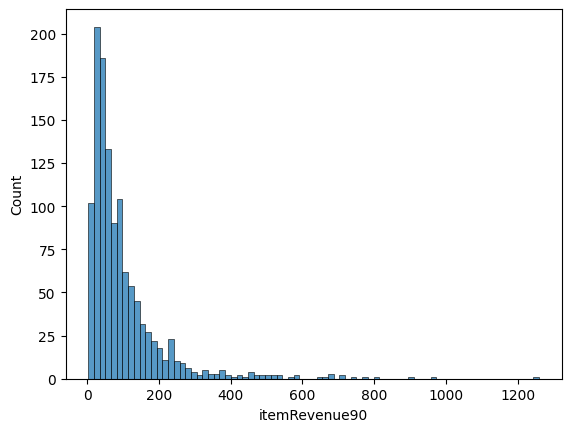

In [18]:
df_bigger0 = merged_df[merged_df['itemRevenue90'] >1]
sns.histplot(data = df_bigger0, x = 'itemRevenue90')

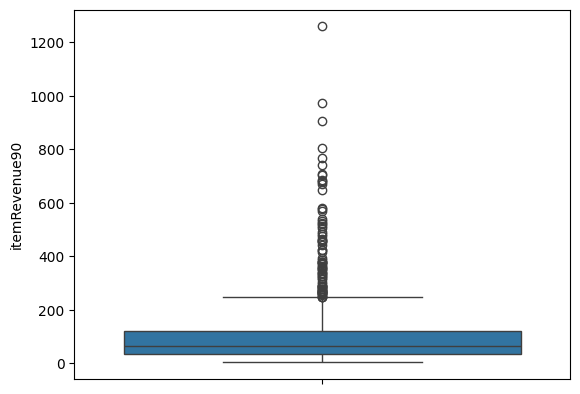

In [19]:
sns.boxplot(data = df_bigger0, y = 'itemRevenue90')
plt.show()

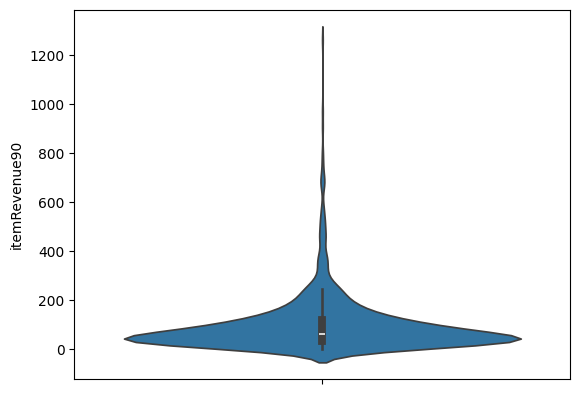

In [20]:
sns.violinplot  (data = df_bigger0, y = 'itemRevenue90')
plt.show()

In [21]:
merged_df['powerUSer'] = merged_df['itemRevenue90'].apply(lambda x: 1 if x>110 else 0)
merged_df.sort_values(by = 'itemRevenue90', ascending = False)

,user_pseudo_id,medium,name,source,mobile_brand_name,country,category,cnt,fdate,sessionCnt,sessionDate,itemBrandCount,itemCatCount,viwePromotion,SelectPromotion,itemViewCnt,itemSelectCnt,paymetInfoAdd,shippingInfoAdd,ScrollpageLocationCnt,ScrollpageTitleCnt,pageViewPageLocationCnt,pageViewPageTitleCnt,itemViews,addToCarts,addToItemId,searchResultViewedCnt,checkOut,ecommercePurchases,purchaseToViewRate,itemPurchaseName,itemPurchaseQuantity,itemRevenue15,itemRevenue2,itemRevenue90,2020,2021,Avg_gdp,powerUSer
448,60695124.4742262801,referral,(referral),shop.googlemerchandisestore.com,Apple,India,tablet,1,2020-11-12,5,2,2,9,0,0,60,0,0,0,9,8,13,12,28,0,0,0,0,0,0.000000,0,0,0.0,0.0,1260.0,1915.552,2250.179,2082.8655,1
36526,12291446.3815334458,organic,(organic),google,<Other>,United States,mobile,1,2020-11-07,7,5,3,25,8,0,139,0,12,9,24,24,35,34,111,14,78,0,14,27,6.306306,16,29,973.0,973.0,973.0,64367.435,70995.794,67681.6145,1
6770,41474740.1017155695,referral,(referral),<Other>,Google,United States,desktop,1,2020-11-21,3,3,3,14,4,0,60,0,1,2,19,18,28,26,15,0,0,0,2,14,13.333333,7,68,904.0,904.0,904.0,64367.435,70995.794,67681.6145,1
41811,39388951.3688006674,organic,(organic),google,<Other>,United States,mobile,1,2020-11-26,4,3,2,14,1,0,68,0,4,4,8,8,16,16,10,0,0,0,4,8,10.000000,8,110,806.0,806.0,806.0,64367.435,70995.794,67681.6145,1
69417,71706603.2631255790,(none),(direct),(direct),Google,Spain,desktop,1,2020-11-20,8,3,2,13,11,0,43,0,8,12,20,19,23,21,51,0,0,6,12,60,23.529412,5,60,768.0,768.0,768.0,26968.374,30563.552,28765.9630,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24129,75097400.6362903193,referral,(referral),<Other>,Apple,Switzerland,mobile,1,2020-11-29,1,1,1,1,1,0,0,0,0,0,1,1,4,4,1,0,0,1,0,0,0.000000,0,0,0.0,0.0,0.0,86105.978,93707.186,89906.5820,0
24130,7511742.5251709685,organic,(organic),google,Apple,United States,tablet,1,2020-11-18,1,1,1,1,1,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0.000000,0,0,0.0,0.0,0.0,64367.435,70995.794,67681.6145,0
24131,75121426.8902574505,organic,(organic),google,Samsung,Spain,mobile,1,2020-11-25,1,1,1,1,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0.000000,0,0,0.0,0.0,0.0,26968.374,30563.552,28765.9630,0
24132,7524007.2904486347,(none),(direct),(direct),Google,United States,desktop,1,2020-11-30,1,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0.000000,0,0,0.0,0.0,0.0,64367.435,70995.794,67681.6145,0


In [22]:
merged_df['perBasket'] = merged_df.apply(
    lambda row: row['itemPurchaseQuantity'] / row['ecommercePurchases'] if row['ecommercePurchases'] != 0 else 0,
    axis=1
)

In [23]:
merged_df['LogGDP'] = np.log(merged_df['Avg_gdp'])
country_filtered = merged_df[merged_df['country'].isin(["United States", "Canada", "Germany", "India", "France", "Taiwan",'Italy', "Japan","Spain", "China", "Singapore", "South Korea", "Netherlands", 'Turkey'])]

In [24]:
country_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 55363 entries, 0 to 71736
Data columns (total 41 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   user_pseudo_id           55363 non-null  object 
 1   medium                   55363 non-null  object 
 2   name                     55363 non-null  object 
 3   source                   55363 non-null  object 
 4   mobile_brand_name        55363 non-null  object 
 5   country                  55363 non-null  object 
 6   category                 55363 non-null  object 
 7   cnt                      55363 non-null  Int64  
 8   fdate                    55363 non-null  dbdate 
 9   sessionCnt               55363 non-null  Int64  
 10  sessionDate              55363 non-null  Int64  
 11  itemBrandCount           55363 non-null  Int64  
 12  itemCatCount             55363 non-null  Int64  
 13  viwePromotion            55363 non-null  Int64  
 14  SelectPromotion          55

In [25]:
country_filtered.mobile_brand_name.unique()

array(['Google', 'Huawei', 'Apple', 'Samsung', '<Other>', 'Xiaomi',
       'Mozilla', 'Microsoft'], dtype=object)

In [26]:
country_filtered.source.unique()

array(['(direct)', '<Other>', 'google', 'shop.googlemerchandisestore.com',
       '(data deleted)'], dtype=object)

In [27]:
df_bigger0 = country_filtered[country_filtered['itemRevenue90'] >1]

C:\Users\w11\AppData\Local\Temp\ipykernel_17512\1241503706.py:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




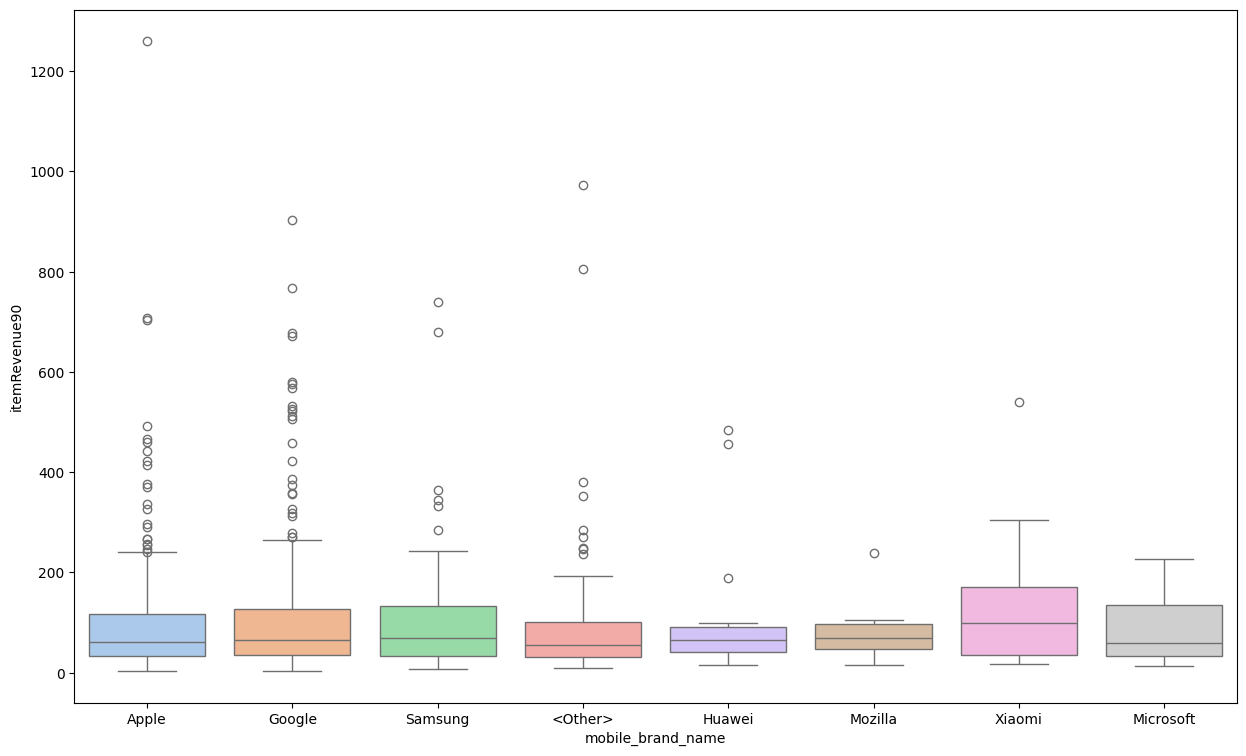

In [28]:
country_filtered_bigger00 = df_bigger0[df_bigger0['country'].isin(["United States", "Canada", "Germany", "India", "France", "Taiwan",'Italy', "Japan","Spain", "China", "Singapore", "South Korea", "Netherlands", 'Turkey'])]
plt.figure(figsize = (15,9))
sns.boxplot(data = df_bigger0, y = 'itemRevenue90', x = 'mobile_brand_name', palette = 'pastel')
plt.show()

In [29]:
country_filtered.mobile_brand_name.value_counts(normalize = True)

mobile_brand_name
Apple        0.423875
Google       0.349800
<Other>      0.075881
Samsung      0.072467
Microsoft    0.024999
Xiaomi       0.023138
Huawei       0.015498
Mozilla      0.014342
Name: proportion, dtype: float64

In [30]:
country_filtered.groupby(['mobile_brand_name','powerUSer'])['itemRevenue90'].mean().sort_values(ascending = False)

mobile_brand_name  powerUSer
Huawei             1            376.333333
<Other>            1            296.250000
Samsung            1            248.285714
Xiaomi             1            239.000000
Google             1            238.951456
Mozilla            1            238.000000
Apple              1            208.174312
Microsoft          1            155.428571
Huawei             0              1.153216
Samsung            0              0.651466
<Other>            0              0.617682
Apple              0              0.616491
Google             0              0.597986
Xiaomi             0              0.468922
Microsoft          0              0.397240
Mozilla            0              0.380832
Name: itemRevenue90, dtype: float64

In [31]:
country_filtered_bigger00.groupby(['mobile_brand_name','powerUSer'])['itemRevenue90'].mean().sort_values(ascending = False)

mobile_brand_name  powerUSer
Huawei             1            376.333333
<Other>            1            296.250000
Samsung            1            248.285714
Xiaomi             1            239.000000
Google             1            238.951456
Mozilla            1            238.000000
Apple              1            208.174312
Microsoft          1            155.428571
Mozilla            0             60.400000
Huawei             0             58.000000
Samsung            0             52.000000
Apple              0             49.823529
Xiaomi             0             49.666667
Google             0             49.437768
<Other>            0             48.773585
Microsoft          0             45.583333
Name: itemRevenue90, dtype: float64

C:\Users\w11\AppData\Local\Temp\ipykernel_17512\3022510854.py:2: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




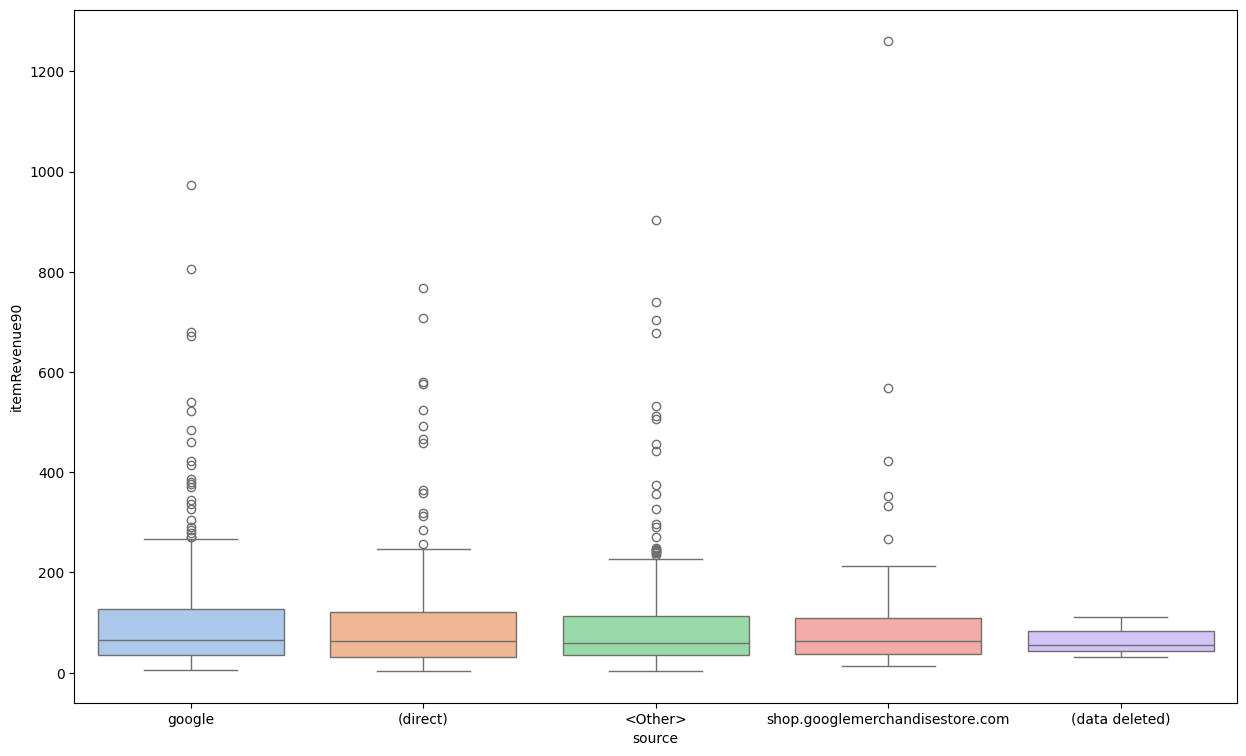

In [32]:
plt.figure(figsize = (15,9))
sns.boxplot(data = df_bigger0, y = 'itemRevenue90', x = 'source', palette = 'pastel')
plt.show()

C:\Users\w11\AppData\Local\Temp\ipykernel_17512\4166446940.py:2: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




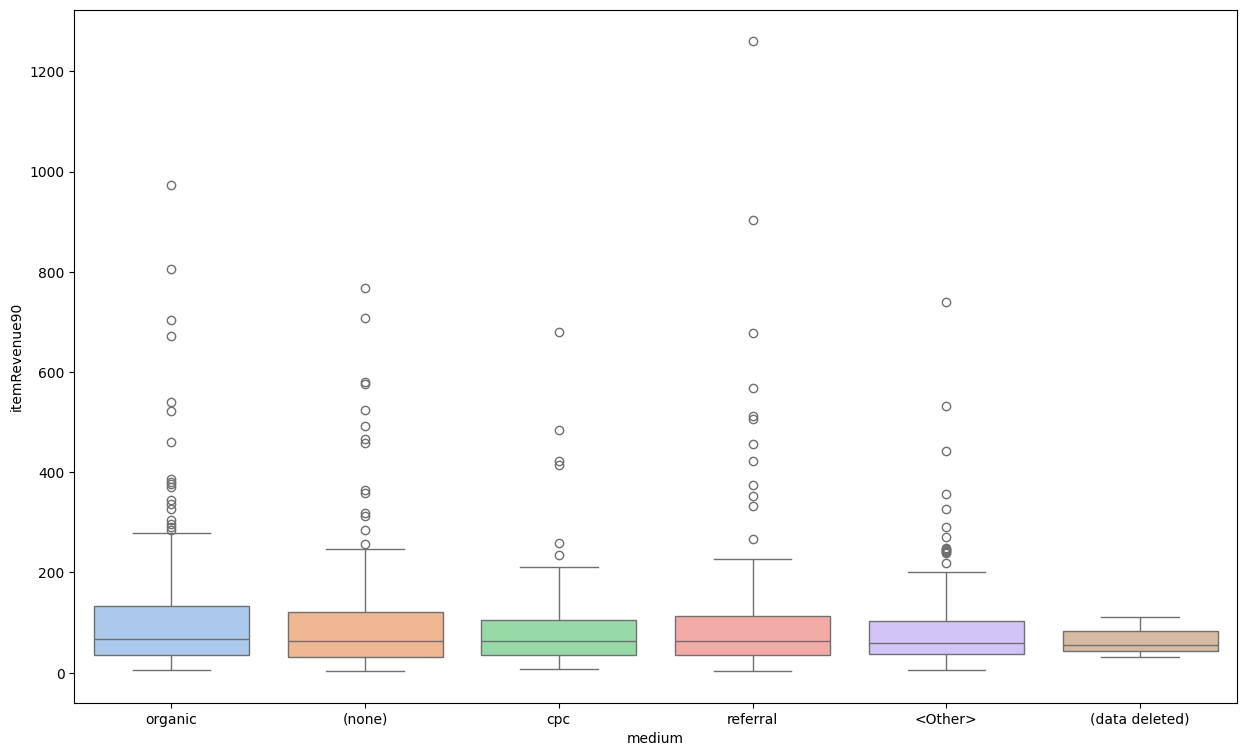

In [33]:
plt.figure(figsize = (15,9))
sns.boxplot(data = df_bigger0, y = 'itemRevenue90', x = 'medium', palette = 'pastel')
plt.show()

C:\Users\w11\AppData\Local\Temp\ipykernel_17512\1637513548.py:2: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




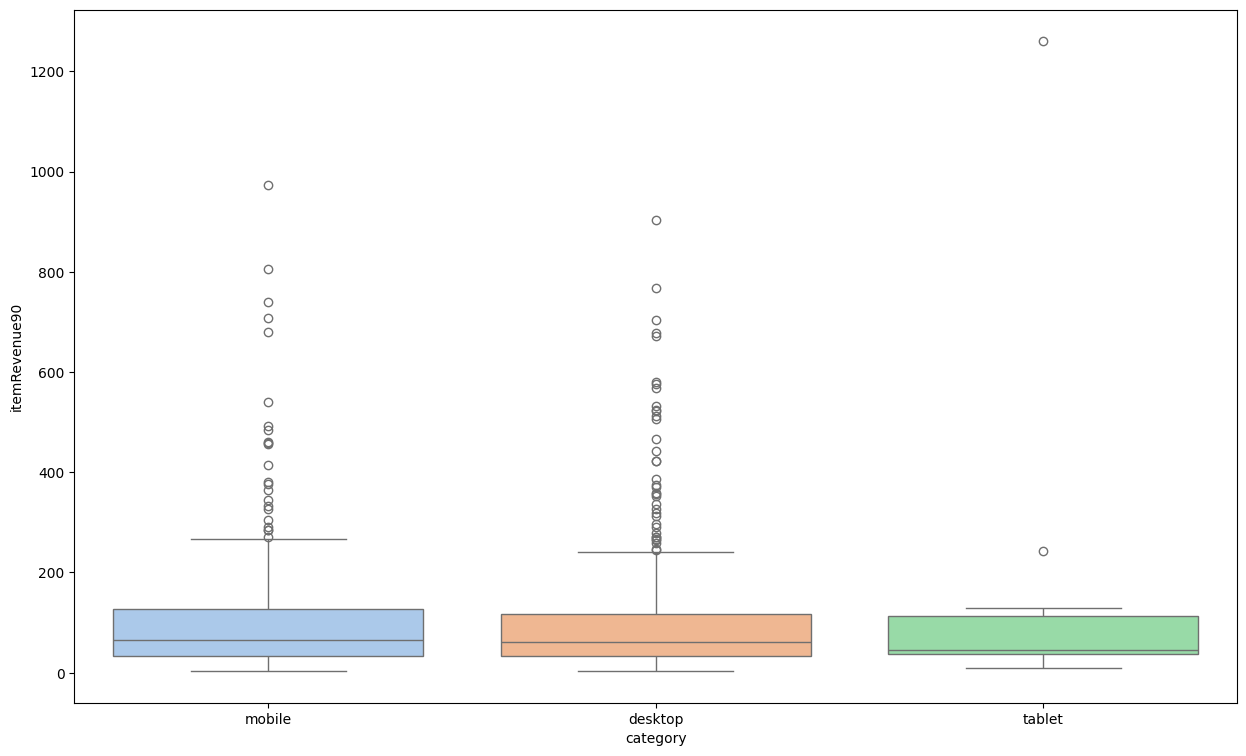

In [34]:
plt.figure(figsize = (15,9))
sns.boxplot(data = df_bigger0, y = 'itemRevenue90', x = 'category', palette = 'pastel')
plt.show()

C:\Users\w11\AppData\Local\Temp\ipykernel_17512\2514704441.py:2: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




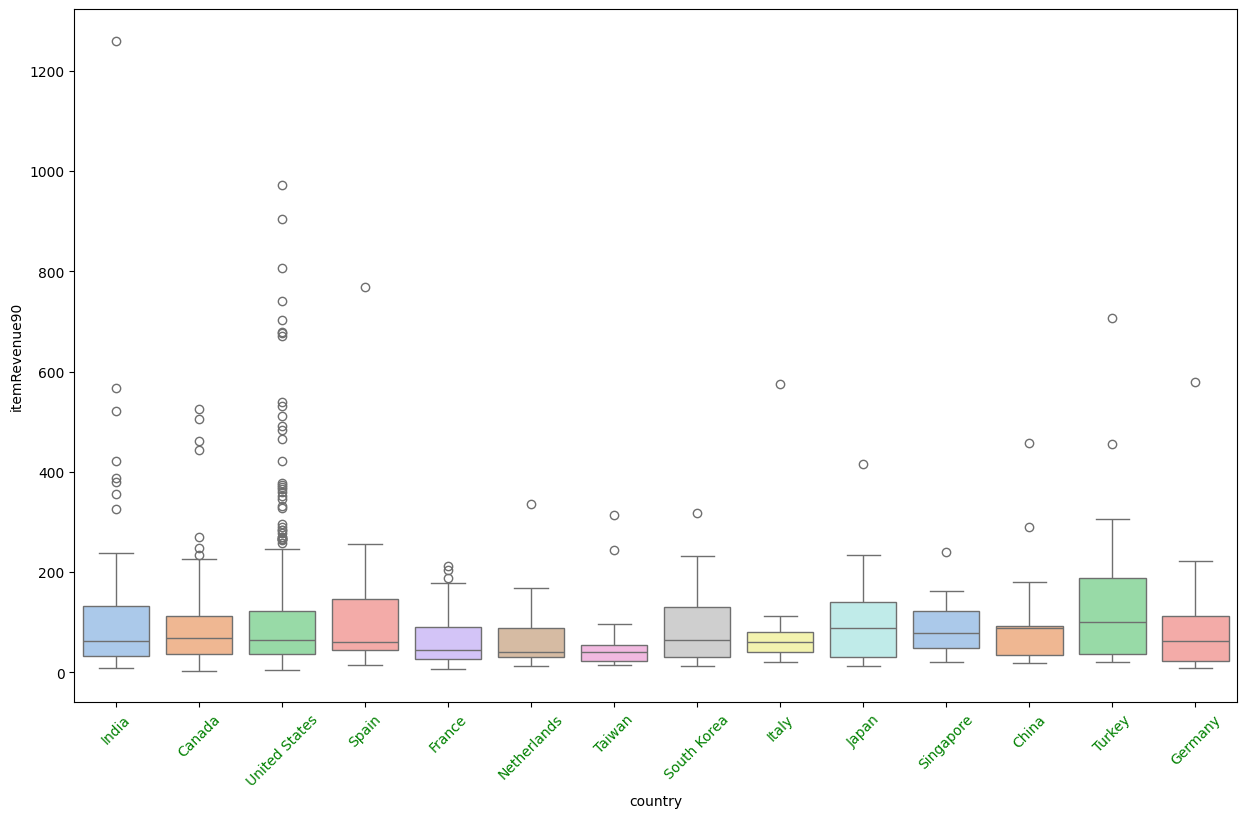

In [35]:
plt.figure(figsize = (15,9))
sns.boxplot(data = df_bigger0, y = 'itemRevenue90', x = 'country', palette = 'pastel')
plt.xticks(rotation = 45, color = 'g')
plt.show()

In [36]:
##country_filtered['powerUSer'] = country_filtered['powerUSer'].astype('category')

In [37]:
merged_num = merged_df.select_dtypes(include = 'number')

In [38]:
merged_num.isnull().sum()

cnt                        0
sessionCnt                 0
sessionDate                0
itemBrandCount             0
itemCatCount               0
viwePromotion              0
SelectPromotion            0
itemViewCnt                0
itemSelectCnt              0
paymetInfoAdd              0
shippingInfoAdd            0
ScrollpageLocationCnt      0
ScrollpageTitleCnt         0
pageViewPageLocationCnt    0
pageViewPageTitleCnt       0
itemViews                  0
addToCarts                 0
addToItemId                0
searchResultViewedCnt      0
checkOut                   0
ecommercePurchases         0
purchaseToViewRate         0
itemPurchaseName           0
itemPurchaseQuantity       0
itemRevenue15              0
itemRevenue2               0
itemRevenue90              0
2020                       0
2021                       0
Avg_gdp                    0
powerUSer                  0
perBasket                  0
LogGDP                     0
dtype: int64

In [39]:
merged_df.isnull().sum()

user_pseudo_id             0
medium                     0
name                       0
source                     0
mobile_brand_name          0
country                    0
category                   0
cnt                        0
fdate                      0
sessionCnt                 0
sessionDate                0
itemBrandCount             0
itemCatCount               0
viwePromotion              0
SelectPromotion            0
itemViewCnt                0
itemSelectCnt              0
paymetInfoAdd              0
shippingInfoAdd            0
ScrollpageLocationCnt      0
ScrollpageTitleCnt         0
pageViewPageLocationCnt    0
pageViewPageTitleCnt       0
itemViews                  0
addToCarts                 0
addToItemId                0
searchResultViewedCnt      0
checkOut                   0
ecommercePurchases         0
purchaseToViewRate         0
itemPurchaseName           0
itemPurchaseQuantity       0
itemRevenue15              0
itemRevenue2               0
itemRevenue90 

In [40]:
merged_num.dropna(inplace = True)
merged_num.isnull().sum()

cnt                        0
sessionCnt                 0
sessionDate                0
itemBrandCount             0
itemCatCount               0
viwePromotion              0
SelectPromotion            0
itemViewCnt                0
itemSelectCnt              0
paymetInfoAdd              0
shippingInfoAdd            0
ScrollpageLocationCnt      0
ScrollpageTitleCnt         0
pageViewPageLocationCnt    0
pageViewPageTitleCnt       0
itemViews                  0
addToCarts                 0
addToItemId                0
searchResultViewedCnt      0
checkOut                   0
ecommercePurchases         0
purchaseToViewRate         0
itemPurchaseName           0
itemPurchaseQuantity       0
itemRevenue15              0
itemRevenue2               0
itemRevenue90              0
2020                       0
2021                       0
Avg_gdp                    0
powerUSer                  0
perBasket                  0
LogGDP                     0
dtype: int64

In [41]:
##sns.pairplot(merged_num)

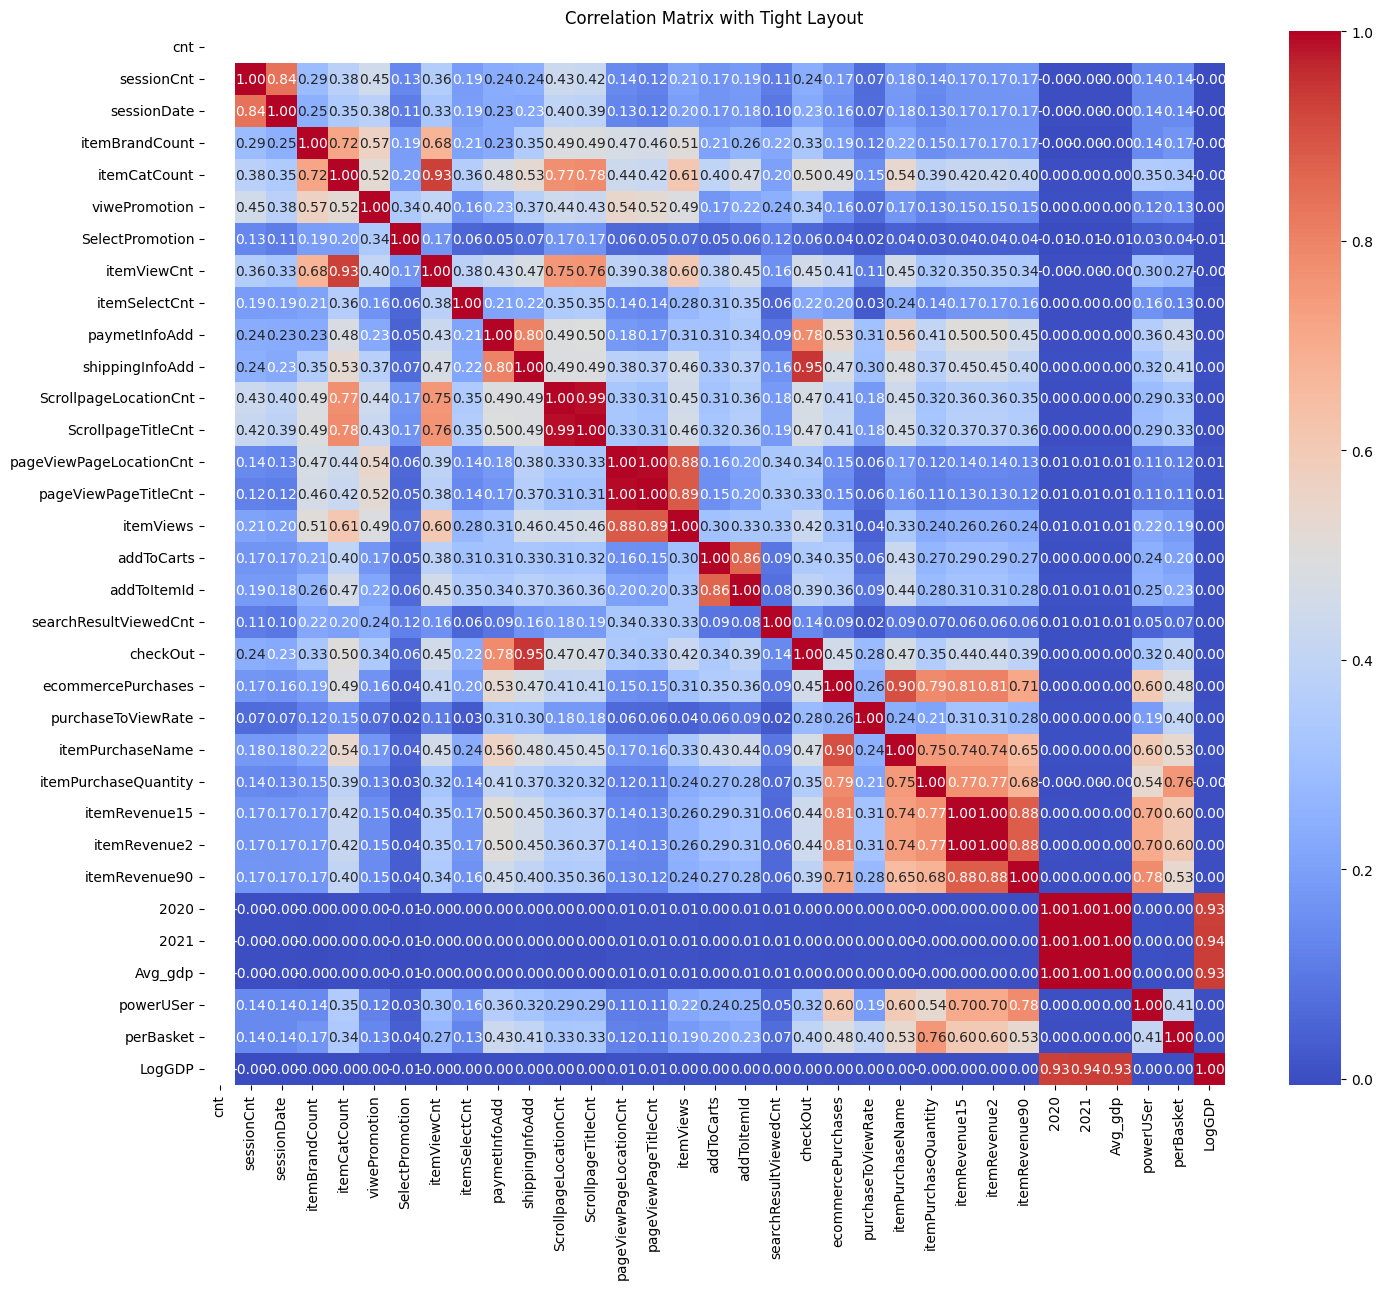

In [42]:
plt.figure(figsize = (15,13))
sns.heatmap(merged_num.corr(), annot = True, fmt = ".2f", cmap = 'coolwarm')
plt.title('Correlation Matrix with Tight Layout')
plt.tight_layout()  # Apply tight layout to ensure proper display of annotations
plt.show()

In [43]:
##sns.pairplot(merged_num, hue = 'powerUSer')

In [44]:
dummies_df = pd.get_dummies(country_filtered[['medium', 'mobile_brand_name', 'country', 'category']], drop_first=True, dtype=int)
dummies_df

,medium_(none),medium_<Other>,medium_cpc,medium_organic,medium_referral,mobile_brand_name_Apple,mobile_brand_name_Google,mobile_brand_name_Huawei,mobile_brand_name_Microsoft,mobile_brand_name_Mozilla,mobile_brand_name_Samsung,mobile_brand_name_Xiaomi,country_China,country_France,country_Germany,country_India,country_Italy,country_Japan,country_Netherlands,country_Singapore,country_South Korea,country_Spain,country_Taiwan,country_Turkey,country_United States,category_mobile,category_tablet
0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0
1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0
2,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0
3,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0
4,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71732,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
71733,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
71734,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
71735,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [45]:
dummy_df = pd.concat([country_filtered,dummies_df], axis = 1)
x = dummy_df.drop(['itemRevenue2','itemRevenue90',  'user_pseudo_id','medium','name','source','mobile_brand_name','country','category','cnt','fdate','powerUSer'], axis = 1).rename(columns = {"medium_(none)":"medium_none","medium_<Other>":"medium_Other"})
y = (dummy_df.powerUSer)

In [46]:
x.head()

,sessionCnt,sessionDate,itemBrandCount,itemCatCount,viwePromotion,SelectPromotion,itemViewCnt,itemSelectCnt,paymetInfoAdd,shippingInfoAdd,ScrollpageLocationCnt,ScrollpageTitleCnt,pageViewPageLocationCnt,pageViewPageTitleCnt,itemViews,addToCarts,addToItemId,searchResultViewedCnt,checkOut,ecommercePurchases,purchaseToViewRate,itemPurchaseName,itemPurchaseQuantity,itemRevenue15,2020,2021,Avg_gdp,perBasket,LogGDP,medium_none,medium_Other,medium_cpc,medium_organic,medium_referral,mobile_brand_name_Apple,mobile_brand_name_Google,mobile_brand_name_Huawei,mobile_brand_name_Microsoft,mobile_brand_name_Mozilla,mobile_brand_name_Samsung,mobile_brand_name_Xiaomi,country_China,country_France,country_Germany,country_India,country_Italy,country_Japan,country_Netherlands,country_Singapore,country_South Korea,country_Spain,country_Taiwan,country_Turkey,country_United States,category_mobile,category_tablet
0,1,1,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0.0,0,0,0.0,64367.435,70995.794,67681.6145,0.0,11.12257,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0
1,1,1,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0.0,0,0,0.0,64367.435,70995.794,67681.6145,0.0,11.12257,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0
2,1,1,0,0,1,0,0,0,0,0,0,0,2,2,0,0,0,0,0,0,0.0,0,0,0.0,64367.435,70995.794,67681.6145,0.0,11.12257,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0
3,1,1,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0.0,0,0,0.0,64367.435,70995.794,67681.6145,0.0,11.12257,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0
4,2,2,1,1,1,0,0,0,0,0,2,2,3,3,0,0,0,0,0,0,0.0,0,0,0.0,64367.435,70995.794,67681.6145,0.0,11.12257,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0


In [47]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=42)

In [48]:
dummy_df['powerUSer'].value_counts(normalize = True)

powerUSer
0    0.995123
1    0.004877
Name: proportion, dtype: float64

## Before Over Sampling XGBoost Classifier

In [49]:
xgb = XGBClassifier().fit(x_train,y_train)
y_pred_xgb = xgb.predict(x_test)
print('Before Over Sampling XGBoost Classifier Confusion Matrix: \n\n', confusion_matrix(y_test, y_pred_xgb))

Before Over Sampling XGBoost Classifier Confusion Matrix: 

 [[16518     0]
 [   26    65]]


In [50]:
def conf_matrix(y_test,y_pred):
    plt.figure(figsize = (10,6))
    sns.heatmap(confusion_matrix(y_test, y_pred), cmap = 'coolwarm', annot = True, fmt= ".0f" ,
               xticklabels=[1,0],
               yticklabels=[1,0])
    plt.xlabel('Predicted Class')
    plt.ylabel("Actual Class")
    plt.title('Confusion Matrix', color = 'r')
    plt.show()

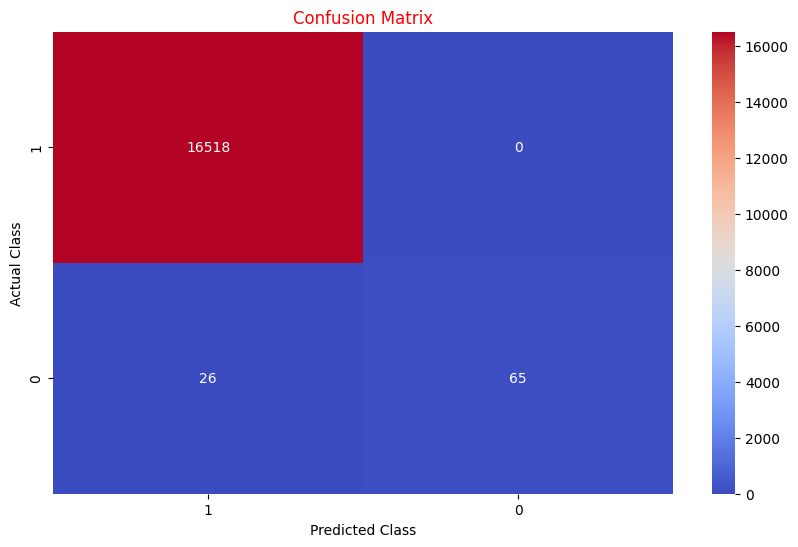

In [51]:
conf_matrix(y_test,y_pred_xgb)

## Before Over Sampling KNN Classifier

In [52]:
# KNN modelini oluşturma

from sklearn.preprocessing import StandardScaler

scale = StandardScaler()

X_train_transformed = scale.fit_transform(x_train)
X_test_transformed = scale.transform(x_test)

knn = KNeighborsClassifier()
knn.fit(X_train_transformed, y_train)
y_pred_knn = knn.predict(X_test_transformed)

print('KNN Training Score: {:6.2f}%'.format(100*knn.score(X_train_transformed, y_train)))
print('KNN Test Score: {:6.2f}%'.format(100*knn.score(X_test_transformed, y_test)))
print('KNN Confusion Matrix: \n\n', confusion_matrix(y_test, y_pred_knn))

KNN Training Score:  99.80%
KNN Test Score:  99.70%
KNN Confusion Matrix: 

 [[16512     6]
 [   44    47]]


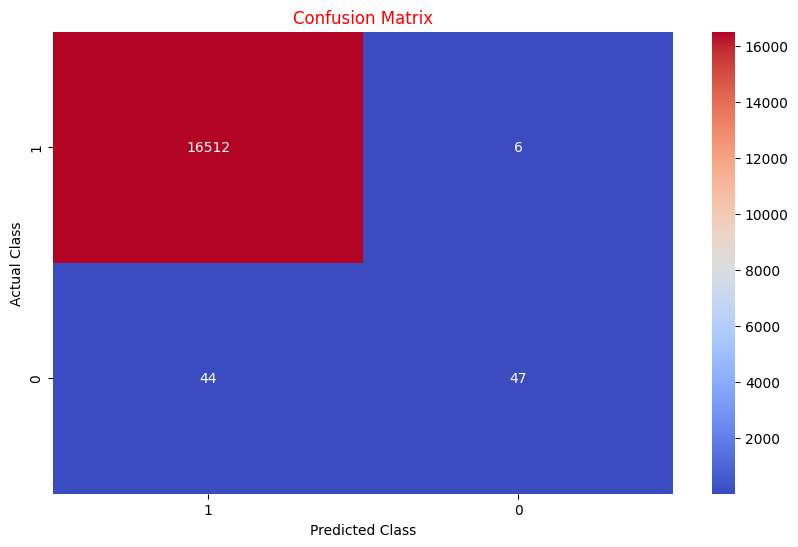

In [53]:
conf_matrix(y_test,y_pred_knn)

## Before Over Sampling Logistic Regression Classifier

In [54]:
# Logistic Regresyon modelini oluşturma
logit = LogisticRegression(solver='liblinear')
logit.fit(X_train_transformed, y_train)
y_pred_logit = knn.predict(X_test_transformed)

print('LogReg Training Score: {:6.2f}%'.format(100*logit.score(X_train_transformed, y_train)))
print('LogReg Test Score: {:6.2f}%'.format(100*logit.score(X_test_transformed, y_test)))
print('Before Over Sampling Logistic Regression Classifier Confusion Matrix: \n\n', confusion_matrix(y_test, y_pred_logit))

LogReg Training Score:  99.89%
LogReg Test Score:  99.77%
Before Over Sampling Logistic Regression Classifier Confusion Matrix: 

 [[16512     6]
 [   44    47]]


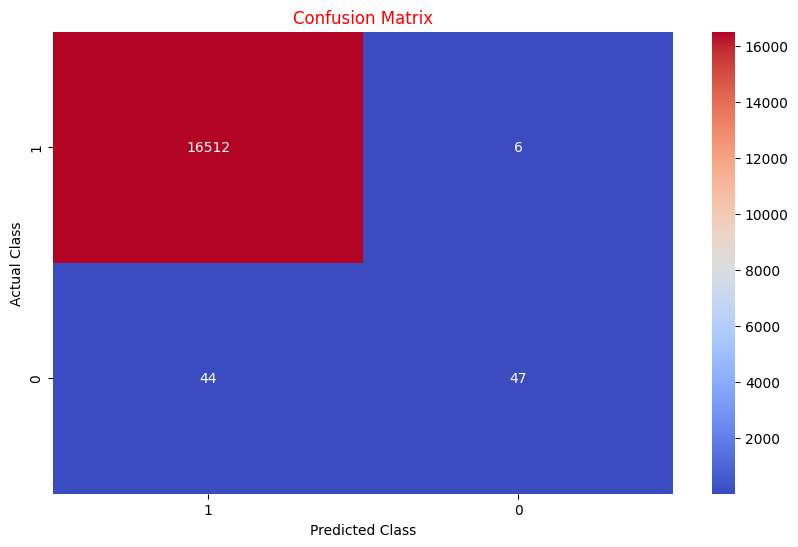

In [55]:
conf_matrix(y_test,y_pred_logit)

In [56]:
print(x_train.shape)
print(y_train.shape)


(38754, 56)
(38754,)


## Random Over Sampling 

In [57]:
from imblearn.over_sampling import RandomOverSampler,SMOTE,ADASYN

In [58]:
ros = RandomOverSampler()
x_resambled , y_resambled = ros.fit_resample(x_train,y_train)

In [59]:
y_resambled

0        0
1        0
2        0
3        0
4        0
        ..
77145    1
77146    1
77147    1
77148    1
77149    1
Name: powerUSer, Length: 77150, dtype: int64

In [60]:
Counter(y_resambled)

Counter({0: 38575, 1: 38575})

In [61]:
xgb_ros = XGBClassifier().fit(x_resambled,y_resambled)
y_pred_ros = xgb_ros.predict(x_test)
print('Random Over Smpling Confusion Matrix: \n\n', confusion_matrix(y_test, y_pred_ros))

Random Over Smpling Confusion Matrix: 

 [[16503    15]
 [   26    65]]


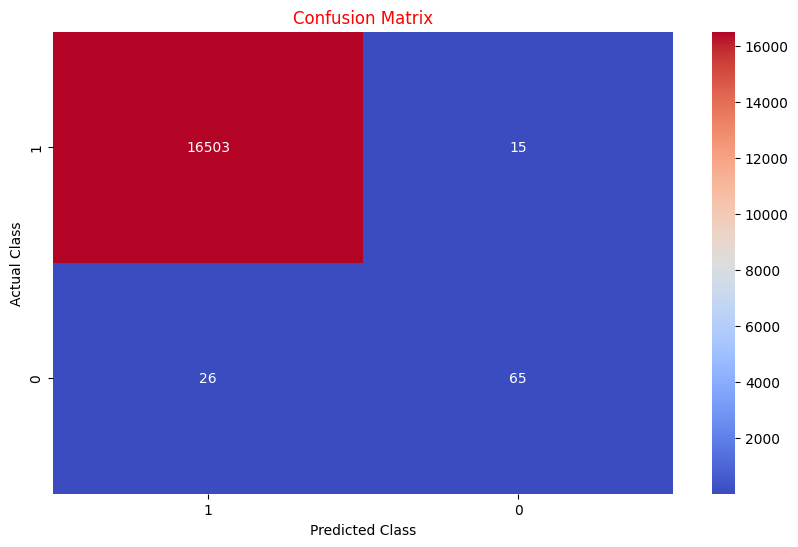

In [62]:
conf_matrix(y_test,y_pred_ros)

In [63]:
y_test.value_counts()

powerUSer
0    16518
1       91
Name: count, dtype: int64

## SMOTE Over Sampling

In [64]:
from imblearn.over_sampling import SMOTE
x_trainf_float = x_train.astype('float64')
smote = SMOTE(k_neighbors=10)  # En düşük değer
x_smoted, y_smoted = smote.fit_resample(x_trainf_float, y_train)

In [65]:
xgb_smote = XGBClassifier().fit(x_smoted,y_smoted)
y_pred_smote = xgb_smote.predict(x_test)
print('SMOTE Over Smpling Confusion Matrix: \n\n', confusion_matrix(y_test, y_pred_smote))

SMOTE Over Smpling Confusion Matrix: 

 [[16517     1]
 [   26    65]]


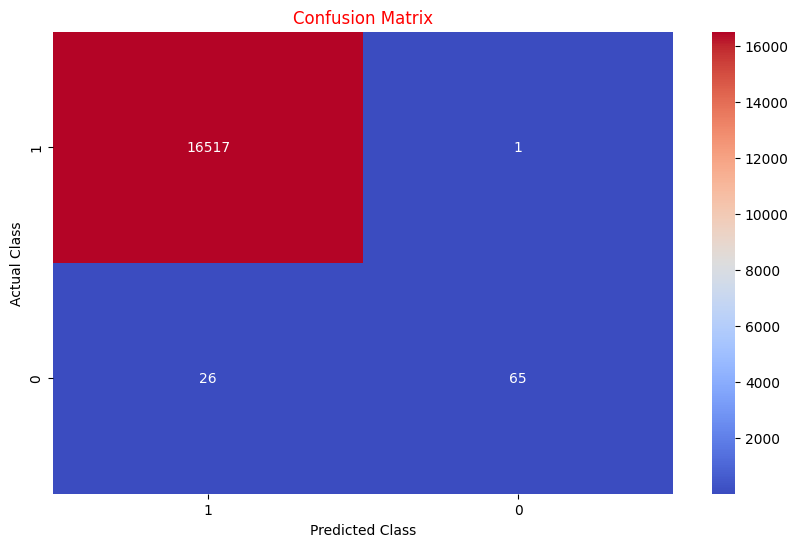

In [66]:
conf_matrix(y_test,y_pred_smote)

## ADASYN Over Sampling

In [67]:
from imblearn.over_sampling import ADASYN
adasyn = ADASYN()
x_adasyn, y_adasyn = adasyn.fit_resample(x_trainf_float, y_train)

In [68]:
xgb_adasyn = XGBClassifier().fit(x_adasyn,y_adasyn)
y_pred_adasyn = xgb_adasyn.predict(x_test)
print('ADASYN Over Smpling Confusion Matrix: \n\n', confusion_matrix(y_test, y_pred_adasyn))

ADASYN Over Smpling Confusion Matrix: 

 [[16514     4]
 [   26    65]]


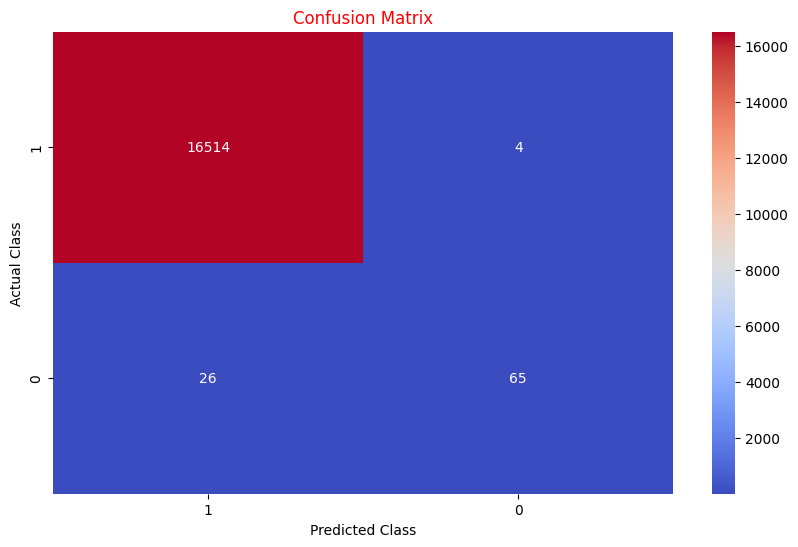

In [69]:
conf_matrix(y_test,y_pred_adasyn)

## KNN Model

In [70]:
# KNN modelini oluşturma

from sklearn.preprocessing import StandardScaler

scale = StandardScaler()

X_train_transformed = scale.fit_transform(x_train)
X_test_transformed = scale.transform(x_test)

knn = KNeighborsClassifier()
knn.fit(X_train_transformed, y_train)
y_pred_knn = knn.predict(X_test_transformed)
recall = recall_score(y_test, y_pred_knn, pos_label=1) 
print('KNN Training Score: {:6.2f}%'.format(100*knn.score(X_train_transformed, y_train)))
print('KNN Recall: {:6.2f}%'.format(100 * recall))

print('KNN Test Score: {:6.2f}%'.format(100*knn.score(X_test_transformed, y_test)))
print('KNN Confusion Matrix: \n\n', confusion_matrix(y_test, y_pred_knn))

KNN Training Score:  99.80%
KNN Recall:  51.65%
KNN Test Score:  99.70%
KNN Confusion Matrix: 

 [[16512     6]
 [   44    47]]


### GridSearchCV for KNN After OverSampling Summary

In [75]:


def knn_model_output(x_train, y_train, x_test, y_test):
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('knn', KNeighborsClassifier())
    ])
    
    # Param Grid's
    param_grid = {
        'knn__n_neighbors': np.arange(1, 31, 2),  # Komşu sayısı için 1 ile 30 arasında değerler
        'knn__weights': ['uniform', 'distance'],  # Ağırlıklandırma tipi
        'knn__metric': ['euclidean', 'manhattan', 'minkowski']  # Mesafe metriği
    }
    
    # GridSearchCV
    grid_search = GridSearchCV(pipe, param_grid, cv=5, scoring='recall', verbose=1)
    
    # Fit GridSearchCV Model
    grid_search.fit(x_train, y_train)
    
    # Best Recall Score and Parameters
    print("Best Params:", grid_search.best_params_)
    print("Best Recall Score:", grid_search.best_score_)
    
    # Retrain model with best parameters on the entire training data
    best_params = grid_search.best_params_
    # Update the pipeline with the best found parameters
    best_knn = Pipeline([
        ('scaler', StandardScaler()),
        ('knn', KNeighborsClassifier(n_neighbors=best_params['knn__n_neighbors'],
                                     weights=best_params['knn__weights'],
                                     metric=best_params['knn__metric']))
    ])
    best_knn.fit(x_train, y_train)
    
    # Predict for test using the best model
    y_pred_knn_best = best_knn.predict(x_test)
    y_prob_knn_best = best_knn.predict_proba(x_test)
    recall_knn_best = recall_score(y_test, y_pred_knn_best)
    logLoss_knn_best = log_loss(y_test, y_prob_knn_best)

    print(f'KNN Best Model Recall: {recall_knn_best}')
    print(f'Knn Best Logg Loss: {logLoss_knn_best}')
    
    # Displaying Confusion Matrix
    cm = confusion_matrix(y_test, y_pred_knn_best)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap='coolwarm', xticklabels=['Predicted 0', 'Predicted 1'],
                yticklabels=['Actual 0', 'Actual 1'])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.show();

# Example usage:
# knn_model_output(x_train, y_train, x_test, y_test)
##Tahmin edilen olasılıkların gerçek etiketlere yakınlığı ne kadar fazla ise, log loss o kadar düşük olur.


Fitting 5 folds for each of 90 candidates, totalling 450 fits
Best Params: {'knn__metric': 'euclidean', 'knn__n_neighbors': 5, 'knn__weights': 'uniform'}
Best Recall Score: 0.5646031746031747
KNN Best Model Recall: 0.5164835164835165
Knn Best Logg Loss: 0.06880126248091441


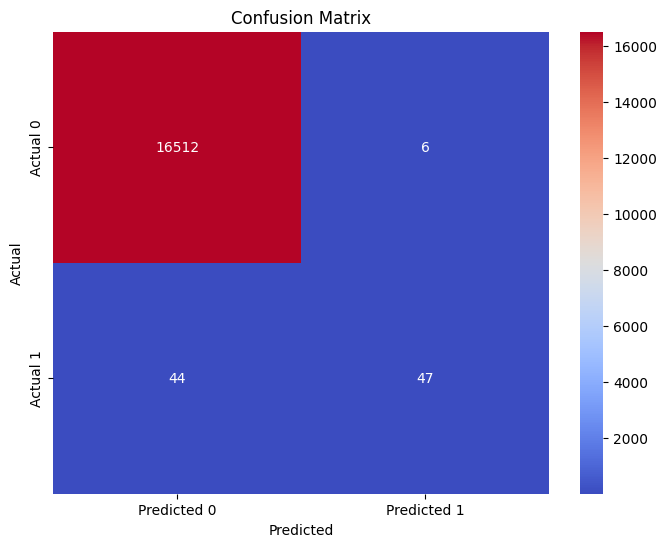

In [76]:
knn_model_output(x_train,y_train,x_test, y_test)

Fitting 5 folds for each of 90 candidates, totalling 450 fits
Best Params: {'knn__metric': 'euclidean', 'knn__n_neighbors': 13, 'knn__weights': 'uniform'}
Best Recall Score: 1.0
KNN Best Model Recall: 0.4725274725274725
Knn Best Logg Loss: 0.15454374124719786


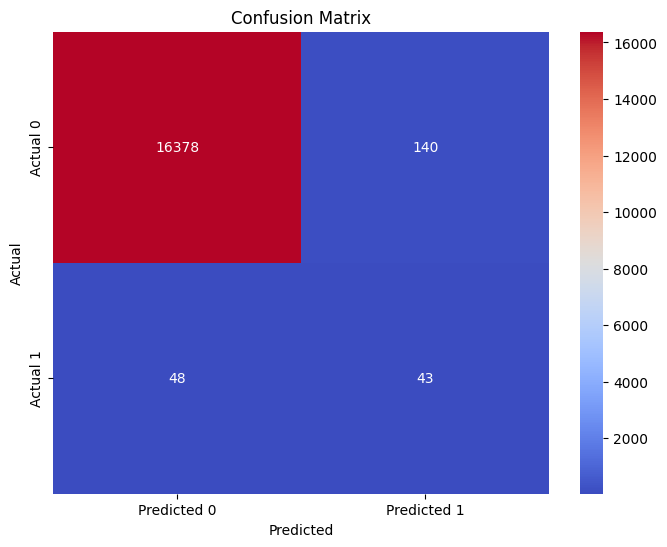

In [77]:
knn_model_output(x_resambled,y_resambled,x_test, y_test)

Fitting 5 folds for each of 90 candidates, totalling 450 fits


Best Params: {'knn__metric': 'euclidean', 'knn__n_neighbors': 1, 'knn__weights': 'uniform'}
Best Recall Score: 0.9939045219985733
KNN Best Model Recall: 0.2857142857142857
Knn Best Logg Loss: 0.24305431871763042


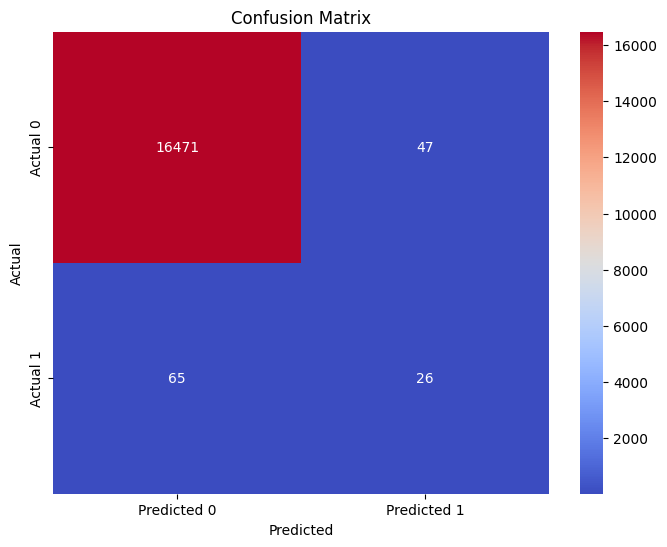

In [78]:
knn_model_output(x_adasyn,y_adasyn,x_test, y_test)

Fitting 5 folds for each of 90 candidates, totalling 450 fits
Best Params: {'knn__metric': 'euclidean', 'knn__n_neighbors': 13, 'knn__weights': 'uniform'}
Best Recall Score: 0.9999222294232016
KNN Best Model Recall: 0.6263736263736264
Knn Best Logg Loss: 0.19132552977733375


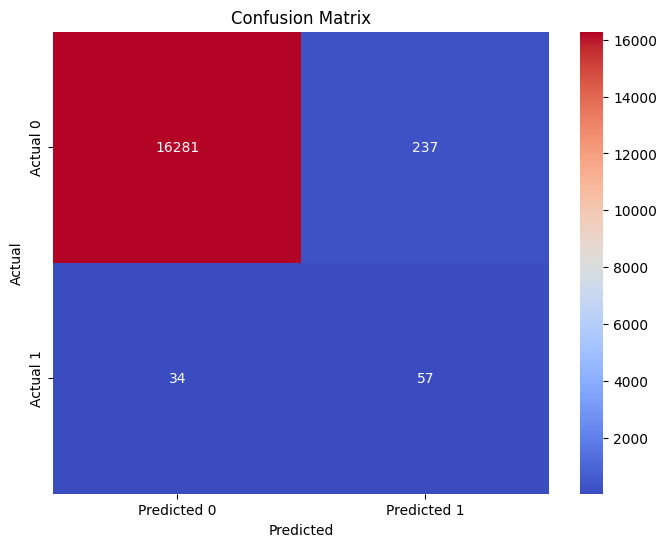

In [79]:
knn_model_output(x_smoted,y_smoted,x_test, y_test)

## XGBOOST GridSearchCV After OverSampling Summary

In [80]:

def xgb_model_output(x_train, y_train, x_test, y_test):
    param_grid = {
        'n_estimators': [50, 100, 150],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7],
        'gamma': [0, 0.1, 0.2],
        'reg_alpha': [0, 0.1],
        'reg_lambda': [1, 2]
    }
    
    xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
    grid_search = GridSearchCV(xgb, param_grid, cv=5, scoring='recall', verbose=1)
    
    # Fit GridSearchCV Model
    grid_search.fit(x_train, y_train)
    
    # Best Recall Score and Parameters
    print("Best Params:", grid_search.best_params_)
    print("Best Recall Score:", grid_search.best_score_)
    
    # Retrain model with best parameters on the entire training data
    best_params = grid_search.best_params_
    xgb_best = XGBClassifier(**best_params, use_label_encoder=False, eval_metric='logloss')
    xgb_best.fit(x_train, y_train)
    
    
    # Predict for test using the best model
    y_pred_xgb_best = xgb_best.predict(x_test)
    y_prob_xgb_best = xgb_best.predict_proba(x_test)
    recall_xgb_best = recall_score(y_test, y_pred_xgb_best)
    LogLoss_xgb_best = log_loss(y_test, y_prob_xgb_best)
    print(f'XGB Best Model Recall: {recall_xgb_best}')
    print(f'XGB Log Loss: {LogLoss_xgb_best}')
    print('XGB Confusion Matrix: \n\n', confusion_matrix(y_test, y_pred_xgb_best))
    
    # Displaying Confusion Matrix
    cm = confusion_matrix(y_test, y_pred_xgb_best)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap='coolwarm', xticklabels=['Predicted 0', 'Predicted 1'],
                yticklabels=['Actual 0', 'Actual 1'])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.show()


Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Best Params: {'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'reg_alpha': 0, 'reg_lambda': 1}
Best Recall Score: 0.8046031746031745
XGB Best Model Recall: 0.7142857142857143
XGB Log Loss: 0.05232625406160536
XGB Confusion Matrix: 

 [[16518     0]
 [   26    65]]


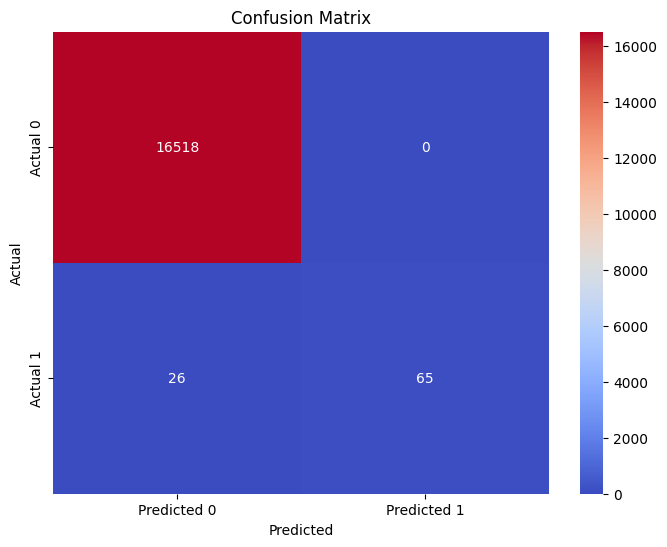

In [81]:
xgb_model_output(x_train, y_train, x_test, y_test)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Best Params: {'gamma': 0, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'reg_alpha': 0, 'reg_lambda': 1}
Best Recall Score: 1.0
XGB Best Model Recall: 0.7142857142857143
XGB Log Loss: 0.026969210535117284
XGB Confusion Matrix: 

 [[16466    52]
 [   26    65]]


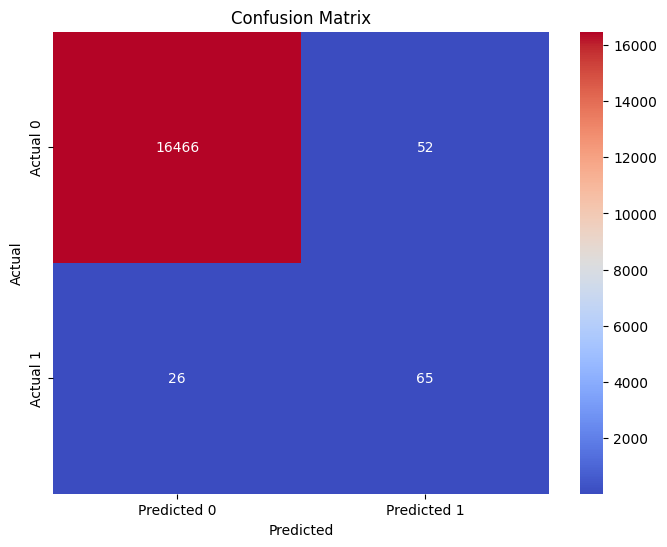

In [82]:
xgb_model_output(x_resambled,y_resambled,x_test, y_test)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Best Params: {'gamma': 0, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 150, 'reg_alpha': 0, 'reg_lambda': 2}
Best Recall Score: 0.999248217757615
XGB Best Model Recall: 0.7142857142857143
XGB Log Loss: 0.014061550626464669
XGB Confusion Matrix: 

 [[16516     2]
 [   26    65]]


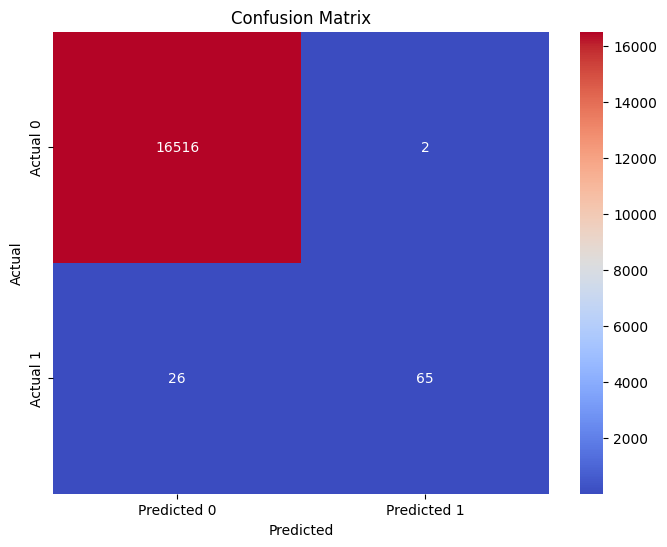

In [83]:
xgb_model_output(x_smoted,y_smoted,x_test, y_test)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Best Params: {'gamma': 0, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 150, 'reg_alpha': 0.1, 'reg_lambda': 2}
Best Recall Score: 0.998469711855703
XGB Best Model Recall: 0.7142857142857143
XGB Log Loss: 0.013312971062456007
XGB Confusion Matrix: 

 [[16518     0]
 [   26    65]]


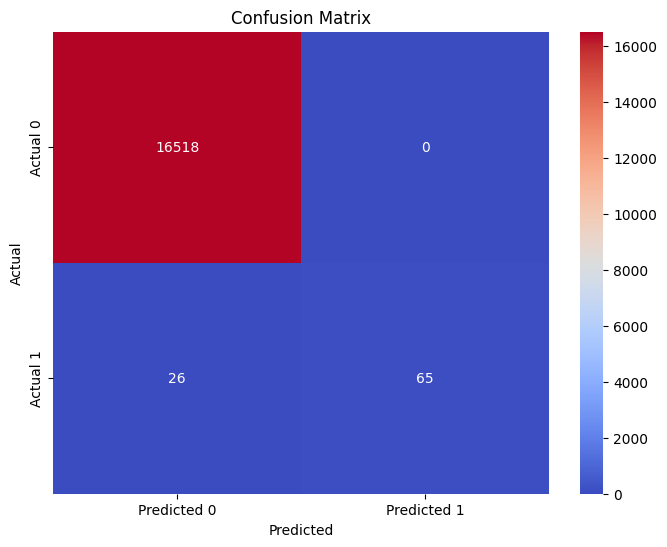

In [84]:
xgb_model_output(x_adasyn,y_adasyn,x_test, y_test)

## Logistic Regression GridSearchCV After OverSampling Summary

In [85]:

def logistic_regression_model_output(x_train, y_train, x_test, y_test):
    # Param Grid's
    param_grid = {
        'C': [0.001, 0.01, 0.1, 1, 10, 100],  # C parametresi değerleri, düzenleme gücü
        'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],  # Kullanılacak algoritma
        'max_iter': [100, 200, 300],  # Maksimum iterasyon sayısı
        'penalty': ['l1', 'l2', 'none']  # Düzenleme türü
    }
    
    logistic = LogisticRegression()
    grid_search = GridSearchCV(logistic, param_grid, cv=5, scoring='recall', verbose=1)
    
    # Fit GridSearchCV Model
    grid_search.fit(x_train, y_train)
    
    # Best Recall Score and Parameters
    print("Best Params:", grid_search.best_params_)
    print("Best Recall Score:", grid_search.best_score_)
    
    # Retrain model with best parameters on the entire training data
    best_params = grid_search.best_params_
    logistic_best = LogisticRegression(**best_params)
    logistic_best.fit(x_train, y_train)
    
    # Predict for test using the best model
    y_pred_logistic_best = logistic_best.predict(x_test)
    y_prob_logistic_best = logistic_best.predict_proba(x_test)
    recall_logistic_best = recall_score(y_test, y_pred_logistic_best)
    LogLoss_logistic_best = log_loss(y_test,y_prob_logistic_best)
    print(f'Logistic Regression Best Model Recall: {recall_logistic_best}')
    print(f'Logistic Regression Best Model Log Loss: {LogLoss_logistic_best}')
    
    # Displaying Confusion Matrix
    cm = confusion_matrix(y_test, y_pred_logistic_best)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap='Greens', xticklabels=['Predicted 0', 'Predicted 1'],
                yticklabels=['Actual 0', 'Actual 1'])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix for Logistic Regression')
    plt.show();

Fitting 5 folds for each of 270 candidates, totalling 1350 fits


c:\Users\w11\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

c:\Users\w11\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

c:\Users\w11\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

c:\Users\w11\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

c:\Users\w11\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

c:\Users\w11\AppData\Local\Programs\Python\Py

Best Params: {'C': 0.1, 'max_iter': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
Best Recall Score: 0.7712698412698413
Logistic Regression Best Model Recall: 0.6703296703296703
Logistic Regression Best Model Log Loss: 0.012124473999237204


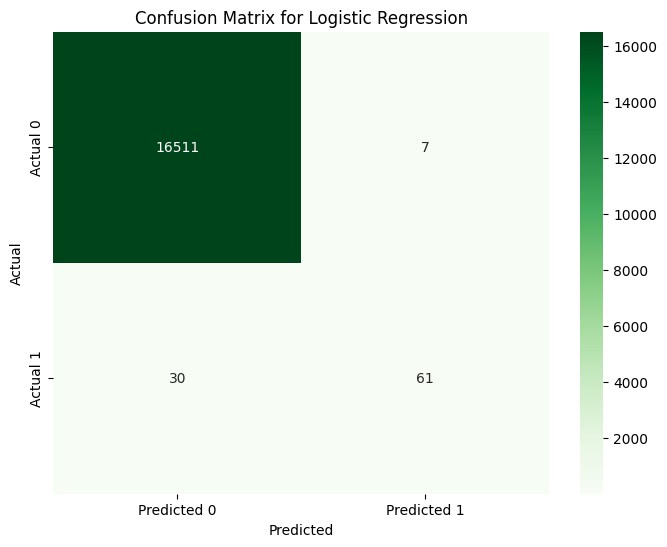

In [86]:
logistic_regression_model_output(x_train, y_train, x_test, y_test)

Fitting 5 folds for each of 270 candidates, totalling 1350 fits


c:\Users\w11\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

c:\Users\w11\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

c:\Users\w11\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

c:\Users\w11\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

c:\Users\w11\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

c:\Users\w11\AppData\Local\Programs\Python\Py

Best Params: {'C': 10, 'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear'}
Best Recall Score: 0.9186001296176279
Logistic Regression Best Model Recall: 0.7802197802197802
Logistic Regression Best Model Log Loss: 0.14458281077578936


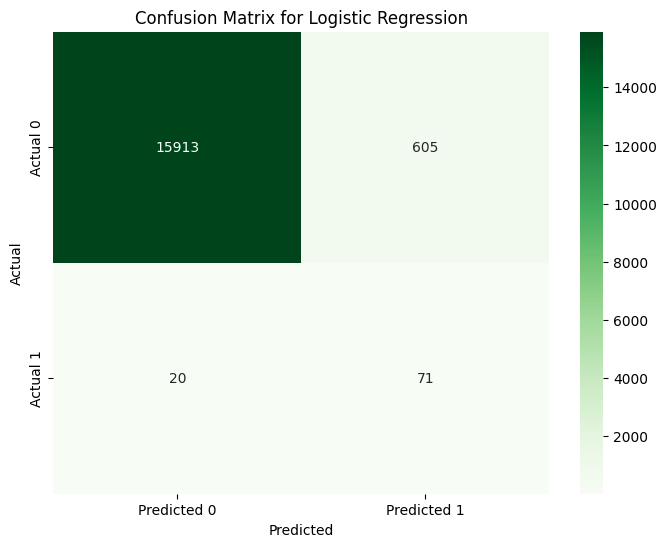

In [87]:
logistic_regression_model_output(x_resambled,y_resambled,x_test, y_test)

Fitting 5 folds for each of 270 candidates, totalling 1350 fits


c:\Users\w11\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

c:\Users\w11\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

c:\Users\w11\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

c:\Users\w11\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

c:\Users\w11\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

c:\Users\w11\AppData\Local\Programs\Python\Python31

Best Params: {'C': 10, 'max_iter': 300, 'penalty': 'l1', 'solver': 'liblinear'}
Best Recall Score: 0.9380168502916396
Logistic Regression Best Model Recall: 0.7692307692307693
Logistic Regression Best Model Log Loss: 0.1264444740300413


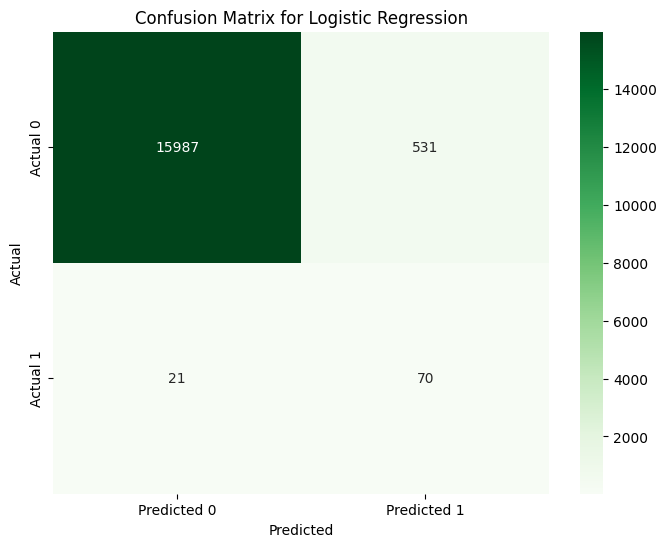

In [88]:
logistic_regression_model_output(x_smoted,y_smoted,x_test, y_test)

Fitting 5 folds for each of 270 candidates, totalling 1350 fits


c:\Users\w11\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

c:\Users\w11\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

c:\Users\w11\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

c:\Users\w11\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

c:\Users\w11\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

c:\Users\w11\AppData\Local\Programs\Python\Python312\Lib\site-p

Best Params: {'C': 1, 'max_iter': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
Best Recall Score: 0.8800915363216024


c:\Users\w11\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\optimize\_linesearch.py:313: LineSearchWarning:

The line search algorithm did not converge

c:\Users\w11\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\optimize.py:74: LineSearchWarning:

The line search algorithm did not converge

c:\Users\w11\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\optimize.py:246: ConvergenceWarning:

newton-cg failed to converge. Increase the number of iterations.



Logistic Regression Best Model Recall: 0.8461538461538461
Logistic Regression Best Model Log Loss: 0.24076959175341803


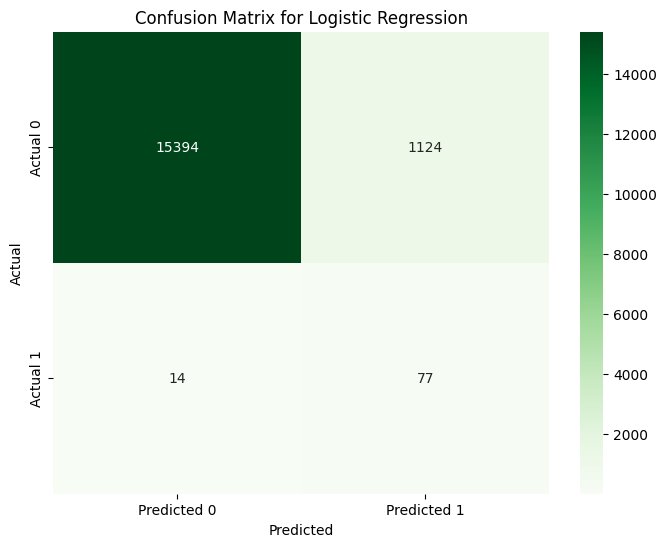

In [89]:
logistic_regression_model_output(x_adasyn,y_adasyn,x_test, y_test)

## Random Forest GridSearchCV After OverSampling Summary

In [90]:

def rf_model_output(x_train, y_train, x_test, y_test):
    # Param Grid's
    param_grid = {
        'n_estimators': [10, 50, 100, 200],       # Ağaç sayısı
        'max_features': ['auto', 'sqrt', 'log2'], # Maksimum özellik sayısı
        'max_depth': [None, 10, 20, 30, 40],      # Maksimum derinlik
        'min_samples_split': [2, 5, 10],          # Bölünme için minimum örnek sayısı
        'min_samples_leaf': [1, 2, 4],            # Yaprakta olması gereken minimum örnek sayısı
        'bootstrap': [True, False]                # Bootstrap örneklerinin kullanımı
    }
    
    rf = RandomForestClassifier()
    grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='recall', verbose=1)
    
    # Fit GridSearchCV Model
    grid_search.fit(x_train, y_train)
    
    # Best Recall Score and Parameters
    print("Best Params:", grid_search.best_params_)
    print("Best Recall Score:", grid_search.best_score_)
    
    # Retrain model with best parameters on the entire training data
    best_params = grid_search.best_params_
    rf_best = RandomForestClassifier(**best_params)
    rf_best.fit(x_train, y_train)
    
    # Predict for test using the best model
    y_pred_rf_best = rf_best.predict(x_test)
    y_prob_rf_best = rf_best.predict_proba(x_test)
    recall_rf_best = recall_score(y_test, y_pred_rf_best)
    LogLoss_rf_best = log_loss(y_test,y_prob_rf_best )
    print(f'Random Forest Best Model Recall: {recall_rf_best}')
    print(f'Random Forest Log Loss: {LogLoss_rf_best}')
    
    # Displaying Confusion Matrix
    cm = confusion_matrix(y_test, y_pred_rf_best)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap='coolwarm', xticklabels=['Predicted 0', 'Predicted 1'],
                yticklabels=['Actual 0', 'Actual 1'])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix for Random Forest')
    plt.show();



Fitting 5 folds for each of 1080 candidates, totalling 5400 fits


c:\Users\w11\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning:


1800 fits failed out of a total of 5400.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1800 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\w11\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\w11\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1467, in wrapper
    estimator._validate_params()
  File "c:\Users\w11\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py"

Best Params: {'bootstrap': False, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 50}
Best Recall Score: 0.8046031746031745
Random Forest Best Model Recall: 0.7032967032967034
Random Forest Log Loss: 0.04491853186357794


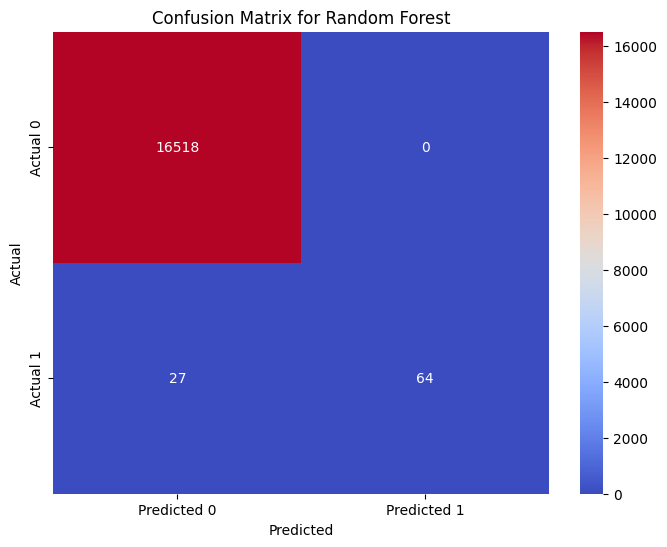

In [91]:
rf_model_output(x_train, y_train, x_test, y_test)

Fitting 5 folds for each of 1080 candidates, totalling 5400 fits


c:\Users\w11\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning:


1800 fits failed out of a total of 5400.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1800 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\w11\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\w11\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1467, in wrapper
    estimator._validate_params()
  File "c:\Users\w11\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py"

Best Params: {'bootstrap': True, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}
Best Recall Score: 1.0
Random Forest Best Model Recall: 0.6373626373626373
Random Forest Log Loss: 0.05115442191232382


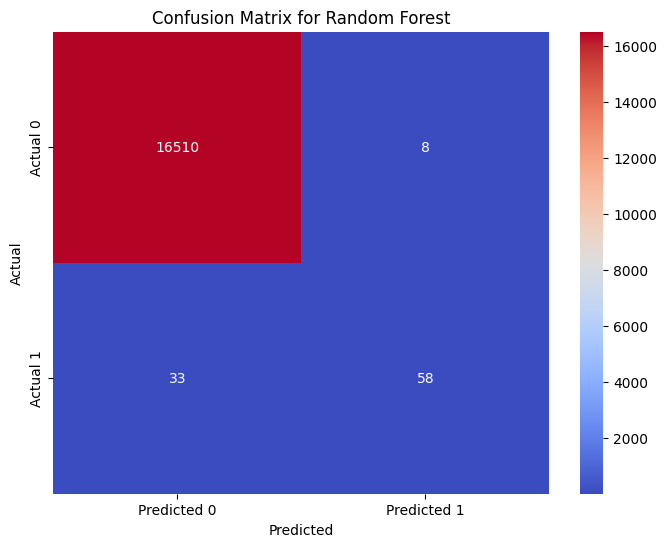

In [92]:
rf_model_output(x_resambled,y_resambled,x_test, y_test)

Fitting 5 folds for each of 1080 candidates, totalling 5400 fits


c:\Users\w11\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning:


1800 fits failed out of a total of 5400.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1800 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\w11\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\w11\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1467, in wrapper
    estimator._validate_params()
  File "c:\Users\w11\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py"

Best Params: {'bootstrap': False, 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Best Recall Score: 0.9992222942320155
Random Forest Best Model Recall: 0.7252747252747253
Random Forest Log Loss: 0.03159308114889868


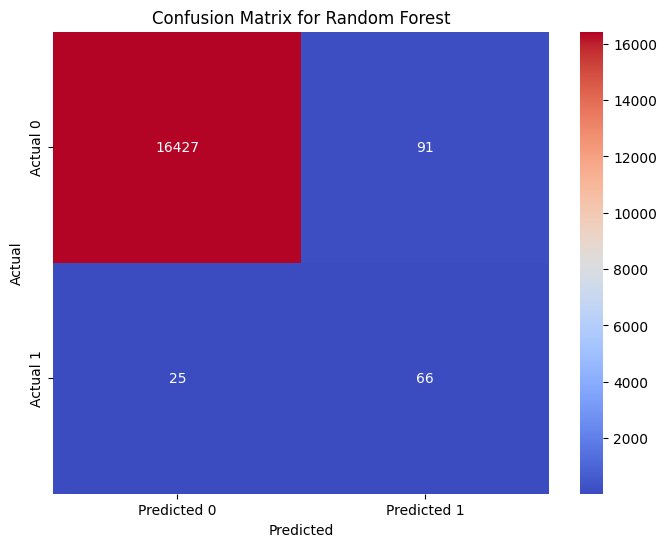

In [93]:
rf_model_output(x_smoted,y_smoted,x_test, y_test)

In [94]:
rf_model_output(x_adasyn,y_adasyn,x_test, y_test)

Fitting 5 folds for each of 1080 candidates, totalling 5400 fits


# SVM GridSearchCV After OverSampling Summary


In [ ]:
def svm_model_output(x_train, y_train, x_test, y_test):
    # Param Grid's
    param_grid = {
        'C': [0.1, 1, 10],               # C parametresi değerleri, hata cezası
        'kernel': ['linear', 'rbf', 'poly'],  # Çekirdek seçenekleri
        'gamma': ['scale', 'auto', 0.01, 0.1, 1],  # Gamma değerleri
        'degree': [2, 3, 4]                   # Polinom derecesi (yalnızca 'poly' çekirdeği için)
    }
    
    svm = SVC()
    grid_search = GridSearchCV(svm, param_grid, cv=5, scoring='recall', verbose=1)
    
    # Fit GridSearchCV Model
    grid_search.fit(x_train, y_train)
    
    # Best Recall Score and Parameters
    print("Best Params:", grid_search.best_params_)
    print("Best Recall Score:", grid_search.best_score_)
    
    # Retrain model with best parameters on the entire training data
    best_params = grid_search.best_params_
    svm_best = SVC(**best_params)
    svm_best.fit(x_train, y_train)
    
    # Predict for test using the best model
    y_pred_svm_best = svm_best.predict(x_test)
    y_prob_svm_best = svm_best.predict_proba(x_test)
    recall_svm_best = recall_score(y_test, y_pred_svm_best)
    print(f'SVM Best Model Recall: {recall_svm_best}')
    print(f'SVM Best Log Loss : {y_prob_svm_best}')
    print('SVM Confusion Matrix: \n\n', confusion_matrix(y_test, y_pred_svm_best))
    
    # Displaying Confusion Matrix
    cm = confusion_matrix(y_test, y_pred_svm_best)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap='coolwarm', xticklabels=['Predicted 0', 'Predicted 1'],
                yticklabels=['Actual 0', 'Actual 1'])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.show()




In [ ]:
svm_model_output(x_train, y_train, x_test, y_test)

In [ ]:
svm_model_output(x_resambled,y_resambled,x_test, y_test)

In [ ]:
svm_model_output(x_smoted,y_smoted,x_test, y_test)

In [ ]:
svm_model_output(x_adasyn,y_adasyn,x_test, y_test)

### **ROC AUC Curve & Treshold Graph for Best Classification Model
### ***Explainable AI Visualization 
### ***Streamlit API Development 

In [ ]:
###